# Water Model Calibration

## TODO
- [x] Generate average model
- [x] Network statistics of pipe locations and sensor locations
- [ ] Add calibrator one by one to map with sensor locations
- [ ] Set up calibrator on node demand
- [ ] For calibrated model, produce time series and compare to actual time series
- [ ] Add ability to track "empty" sensors in order to see sensitivities of different locations as candidates for future sensors
- [ ] Run final calibrated model and compare more or all sensors to that one iteration
- [ ] Add selection criteria based upon pipes being evaluated
- [ ] Create objective functions, no matter how imperfect
    - [x] Acceptance Rate
    - [x] Closeness of fit
    - [x] Standard deviation
    - [ ] Sensor closeness of fit

# Set Up

In [1]:
import wntr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy as sp
import chaospy as cp
from ipypb import track
from matplotlib import cm
import pickle
import datetime as dt
import networkx as nx

# Helper Methods

In [2]:
def savePickle(dataDict,picklePath):
    dataDict["timestamp"] = dt.datetime.now()
    pickle.dump( dataDict, open( picklePath, "wb" ) )

In [3]:
def loadPickle(picklePath):
    dataDict = pickle.load( open( picklePath, "rb" ) )
    return dataDict

In [4]:
def extractDataFrame(wn,objType="Pipe"):
    objsDict = {}
    try:
        objIter = wn.pipes()
        if objType == "Junction":
            objIter = wn.junctions()
        elif objType == "Tank":
            objIter = wn.tanks()
        elif objType == "Reservoir":
            objIter = wn.reservoirs()
        for obj in objIter:
            obj = obj[1]
            objDict = obj.todict()
            for k,v in objDict.items():
                if k in objsDict.keys():
                    objsDict[k].append(v)
                else:
                    objsDict[k] = [v]
        objsDF = pd.DataFrame(objsDict)
        return objsDF
    except:
        return objsDict

In [5]:
class ResultHelper():
    def __init__(self,results,convertResultsToHours=True):
        self.results = results
        
        # programatically set nodes
        for nodeKey in results.node.keys():
            self.__dict__[nodeKey] = results.node[nodeKey].T
        
        # progrmatically set links
        for linkKey in results.link.keys():
            self.__dict__[linkKey] = results.link[linkKey].T
        
        if convertResultsToHours:
            self.convertResultsToHours()
            
    def help(self):
        return list(self.__dict__.keys())
        
    def convertResultsToHours(self):
        for prop,value in self.__dict__.items():
            if type(value) == pd.DataFrame:
                value.columns = [float(seconds)/3600.0 for seconds in value.columns]
                
    def returnResult(self,resultType,resultLocationID,time):
        if resultType in self.__dict__.keys():
            resultDF = self.__dict__[resultType]
            if resultLocationID in resultDF.index:
                if time in resultDF.columns:
                    return self.__dict__[resultType].loc[resultLocationID][time]
                else:
                    print(f"{time} is not a valid time")
            else:
                print(f"{resultLocationID} is not a valid element in the network")
        else:
            print(f"{resultType} is not a valid property for ResultAnalyzer")
            return None

In [6]:
class Sensor():
    def __init__(self,sensorType,name,sensorSTD,dictOfPropertyValues):
        self.sensorType = sensorType
        self.name = name
        self.sensorSTD = sensorSTD
        self.dictOfPropertyValues = dictOfPropertyValues
        self.dictOfPropertyModelEstimates = {k:[] for k in dictOfPropertyValues.keys()}
        
    def retrieveModelResults(self,resultHelper):
        sensorModelResults = {}
        for sensorObservationTime,sensorObservationValue in self.dictOfPropertyValues.items():
            modelResult = resultHelper.returnResult(self.sensorType,self.name,sensorObservationTime)
            sensorModelResults[sensorObservationTime] = modelResult
        return sensorModelResults
    
    def calculateProbability(self,resultHelper):
        p = 1.0
        for sensorObservationTime,sensorObservationValue in self.dictOfPropertyValues.items():
            modelResult = resultHelper.returnResult(self.sensorType,self.name,sensorObservationTime)
            self.dictOfPropertyModelEstimates[sensorObservationTime].append(modelResult)
            distribution = stats.norm(sensorObservationValue,self.sensorSTD)
            p *= distribution.pdf(modelResult)
        return p
    
    def calculateProbability_Summed(self,resultHelper):
        p = 0.0
        for sensorObservationTime,sensorObservationValue in self.dictOfPropertyValues.items():
            modelResult = resultHelper.returnResult(self.sensorType,self.name,sensorObservationTime)
            self.dictOfPropertyModelEstimates[sensorObservationTime].append(modelResult)
            distribution = stats.norm(modelResult,self.sensorSTD)
            p += distribution.pdf(sensorObservationValue)
        return p        
    
    def calculateProbability_Summed_Log(self,resultHelper):
        p = 0.0
        for sensorObservationTime,sensorObservationValue in self.dictOfPropertyValues.items():
            modelResult = resultHelper.returnResult(self.sensorType,self.name,sensorObservationTime)
            self.dictOfPropertyModelEstimates[sensorObservationTime].append(modelResult)
            distribution = stats.norm(modelResult,self.sensorSTD)
            p += np.log(distribution.pdf(sensorObservationValue))
        return p       

In [11]:
class WaterNetworkHelper():
    def __init__(self,wn,name="Water Network"):
        self.wn = wn
        self.updatePipes()
        self.name = name
        self.generateNetworkStatistics()
        
    def updatePipes(self):
        self.pipes = extractDataFrame(self.wn).set_index("name")
        self.nodes = extractDataFrame(self.wn,"Junction").set_index("name")
        self.tanks = extractDataFrame(self.wn,"Tank").set_index("name")
        self.reservoirs = extractDataFrame(self.wn,"Reservoir").set_index("name")
        
    def setPipeDiameter(self,pipeID,newDiameter):
        pipe = self.wn.get_link(pipeID)
        pipe.diameter = newDiameter
        self.updatePipes()
    
    def setPipeRoughness(self,pipeID,newRoughness):
        pipe = self.wn.get_link(pipeID)
        pipe.roughness = newRoughness
        self.updatePipes()
    
    def setPipeStatus(self,pipeID,newStatus):
        pipe = self.wn.get_link(pipeID)
        pipe.status = newStatus
        self.updatePipes()
        
    def setNodeDemand(self,nodeID,newDemand):
        node = self.wn.get_node(nodeID)
        node.demand_timeseries_list[0].base_value = newDemand
        self.updatePipes()
    
    def generateNetworkStatistics(self):
        pipes = self.pipes
        G = self.wn.get_graph()
        nodeDegrees = G.degree()
        linkBridges = G.bridges()
        terminalNodes = G.terminal_nodes()
        nodeDegreeCentralities = nx.degree_centrality(G)
        nodeCurrentFlowBetweennessCentralities = nx.current_flow_betweenness_centrality(G.to_undirected())
        nodeLoadCentralities = nx.load_centrality(G)

        currentRank = 0
        voteRankOrders = {}
        for i,orderedVoteRank in enumerate(nx.voterank(G.to_undirected())):
            voteRankOrders[orderedVoteRank] = currentRank
            currentRank += 1
        # add nodes with no rank, in arbitrary list order
        for node in list(G.nodes):
            if node not in voteRankOrders.keys():
                voteRankOrders[node] = currentRank
                currentRank += 1

        start_node_degrees = []
        end_node_degrees = []
        highest_node_degrees = []

        link_is_bridges = []

        includes_terminal_nodes = []

        start_node_degree_centralities = []
        end_node_degree_centralities = []
        highest_node_degree_centralities = []

        start_node_current_flow_betweenness_centralities = []
        end_node_current_flow_betweenness_centralities = []
        highest_node_current_flow_betweenness_centralities = []

        start_node_vote_rank_orders = []
        end_node_vote_rank_orders = []
        highest_node_vote_rank_orders = []

        start_node_degree_load_centralities = []
        end_node_degree_load_centralities = []
        highest_node_degree_load_centralities = []

        for pipe,row in pipes.iterrows():
            start_node_name = row["start_node_name"]
            end_node_name = row["end_node_name"]
            
            # Node degree
            start_node_degrees.append(nodeDegrees[start_node_name])
            end_node_degrees.append(nodeDegrees[end_node_name])
            highest_node_degrees.append(max(nodeDegrees[start_node_name],nodeDegrees[end_node_name]))

            # Link bridges
            if pipe in linkBridges:
                link_is_bridges.append(True)
            else:
                link_is_bridges.append(False)
            # Terminal Nodes
            if start_node_name in terminalNodes or end_node_name in terminalNodes:
                includes_terminal_nodes.append(True)
            else:
                includes_terminal_nodes.append(False)

            # Node degree centralities
            start_node_degree_centralities.append(nodeDegreeCentralities[start_node_name])
            end_node_degree_centralities.append(nodeDegreeCentralities[end_node_name])    
            highest_node_degree_centralities.append(max(nodeDegreeCentralities[start_node_name],nodeDegreeCentralities[end_node_name]))

            # Node current flow betweenness centralities
            start_node_current_flow_betweenness_centralities.append(nodeCurrentFlowBetweennessCentralities[start_node_name])
            end_node_current_flow_betweenness_centralities.append(nodeCurrentFlowBetweennessCentralities[end_node_name])
            highest_node_current_flow_betweenness_centralities.append(max(nodeCurrentFlowBetweennessCentralities[start_node_name],nodeCurrentFlowBetweennessCentralities[end_node_name]))

            # Node vote rank orders
            start_node_vote_rank_orders.append(voteRankOrders[start_node_name])
            end_node_vote_rank_orders.append(voteRankOrders[end_node_name])
            highest_node_vote_rank_orders.append(min(voteRankOrders[start_node_name],voteRankOrders[end_node_name]))

            # Load centralities
            start_node_degree_load_centralities.append(nodeLoadCentralities[start_node_name])
            end_node_degree_load_centralities.append(nodeLoadCentralities[end_node_name])
            highest_node_degree_load_centralities.append(max(nodeLoadCentralities[start_node_name],nodeLoadCentralities[end_node_name]))

        pipes["start_node_degree"] = start_node_degrees
        pipes["end_node_degree"] = end_node_degrees
        pipes["link_is_bridge"] = link_is_bridges
        pipes["includes_terminal_node"] = includes_terminal_nodes
        pipes["start_node_degree_centrality"] = start_node_degree_centralities
        pipes["end_node_degree_centrality"] = end_node_degree_centralities
        pipes["start_node_current_flow_betweenness_centrality"] = start_node_current_flow_betweenness_centralities
        pipes["end_node_current_flow_betweenness_centrality"] = end_node_current_flow_betweenness_centralities
        pipes["start_node_vote_rank_order"] = start_node_vote_rank_orders
        pipes["end_node_vote_rank_order"] = end_node_vote_rank_orders
        pipes["start_node_degree_load_centrality"] = start_node_degree_load_centralities
        pipes["end_node_degree_load_centrality"] = end_node_degree_load_centralities

        pipes["highest_node_degree"] = highest_node_degrees
        pipes["highest_node_degree_centrality"] = highest_node_degree_centralities
        pipes["highest_node_current_flow_betweenness_centrality"] = highest_node_current_flow_betweenness_centralities
        pipes["highest_node_vote_rank_order"] = highest_node_vote_rank_orders
        pipes["highest_node_degree_load_centrality"] = highest_node_degree_load_centralities
            
    def runSimulation(self):
        sim = wntr.sim.EpanetSimulator(self.wn)
        results = ResultHelper(sim.run_sim())
        return results        
    
    def plotNetwork(self,figsize=(10,10),link_attribute=None,node_attribute=None):
        fig,ax = plt.subplots(figsize=figsize)
        wntr.graphics.plot_network(self.wn, title=self.name,ax=ax,node_attribute=node_attribute,link_attribute=link_attribute)

In [12]:
class Calibrator():
    def __init__(self,elementName,elementProperty,distribution,trueValue=None):
        self.elementName = elementName
        self.elementProperty = elementProperty
        self.prior = distribution # type of distribution
        self.values = []
        self.proposedValues = []
        self.trueValue = trueValue
        
    def generateProposal(self):
        return self.prior.rvs()
    
    def generateTransition(self,currentValue=None,σ=None):
        if not currentValue:
            currentValue = self.values[-1]
        if not σ:
            σ = self.prior.std()
        # simple gaussian case
        dist = stats.norm(currentValue,σ)
        return dist.rvs()
    
    def calculateProbability(self,value):
        return self.prior.pdf(value)
    
    def calculateProbability_Transition(self,value):
        dist = stats.norm(self.values[-1],self.prior.std())
        return dist.pdf(value)
    
    def fitDistribution(self,dist=stats.norm):
        params = dist.fit(calibrator.values)
        return params
        
    def setValue(self,waterNetworkHelper,newValue):
        if self.elementProperty == "diameter":
            waterNetworkHelper.setPipeDiameter(self.elementName,newValue)
        elif self.elementProperty == "roughness":
            waterNetworkHelper.setPipeRoughness(self.elementName,newValue)
        elif self.elementProperty == "status":
            waterNetworkHelper.setPipeStatus(self.elementName,newValue)
            
    def setValueToResult(self,waterNetworkHelper,resultMetric="mean",burnin=0.0):
        resultWithBurnin = self.values[int(burnin*len(self.values)):]
        result = np.mean(resultWithBurnin)
        if resultMetric == "median":
            result = np.median(resultWithBurnin)
        
        self.setValue(waterNetworkHelper,result)
            
    def plot(self,trueValue,burnin=0.0,ax=None,acceptanceRate=None):
        columnName = f"{self.elementName} {self.elementProperty}"
        valuesSubset = self.values[int(burnin*len(self.values)):len(self.values)+1]
        calibratorDFToPlot = pd.DataFrame({columnName:valuesSubset})
        if not ax:
            fig,ax = plt.subplots(figsize=(10,10))
        calibratorDFToPlot.plot(kind="hist",ax=ax,legend=False,density=True)
        ax.axvline(trueValue,color="red",ls="--",label="True Value")
        title = f'{columnName}\nCalibrated Mean: {calibratorDFToPlot[columnName].mean():.1f}, Calibrated Median: {calibratorDFToPlot[columnName].median():.1f}\nTrue Value: {trueValue:.1f}, Prior Mean: {self.prior.mean():.1f}'
        if acceptanceRate:
            title += f"\nAcceptance Rate: {acceptanceRate*100.0:.2f}%"
        scores = self.score(burnin=burnin)
        title += f'\nPercent Difference: {scores["Fraction Difference"]*100.0:.2f}%, STD: {scores["Standard Deviation"]:.2f}'
        ax.set_title(title)
        ax.set_xlabel(self.elementProperty)
        
        # add the prior distribution
        priorEstimates = []
        
        lspace = np.linspace(0,220,10000)
        ns = self.prior.pdf(lspace)
        sns.lineplot(lspace,ns,ax=ax,color="orange",alpha=0.2,label="Prior")
        ax.fill_between(lspace,ns, color="orange", alpha=0.1)
        
#         for i in range(0,10000):
#             priorEstimates.append(self.generateProposal())
#         priorEstimatesDF = pd.DataFrame({"Prior":priorEstimates})
#         priorEstimatesDF.plot(kind="hist",ax=ax,color="orange",alpha=0.1,label="Prior",density=True)
        return ax

    def plotParameterValues(self,burnin=0.0,ax=None):
        if not ax:
            fig,ax = plt.subplots(figsize=(10,10))
        pd.DataFrame({"Accepted Values":self.values}).plot(kind="line",ax=ax,label="Accepted Values")
        pd.DataFrame({"Proposed Values":self.proposedValues}).plot(kind="line",ax=ax,color="grey",alpha=0.1,label="Proposed Values")
        ax.axhline(self.trueValue,ls="--",color="red",label="True Value")
        ax.set_title(f"{self.elementName} {self.elementProperty}");
        ax.axvspan(0,int(burnin*len(self.values)),alpha=0.05,color="red",label="Burn In Discard Range")
        ax.legend()
        return ax
        

    def plotRollingAverage(self,trueValue,burnin=0.0,ax=None,pointAlpha=0.1):
        if not ax:
            fig,ax = plt.subplots(figsize=(10,5))
            
        rollingAverages = []
        for i in range(1,len(self.values)):
            rollingAverages.append(np.mean(self.values[0:i]))
        sns.lineplot(range(1,len(self.values)),rollingAverages,ax=ax)
        ax.set_title(f"{self.elementName} {self.elementProperty} Rolling Average")
        ax.set_xlabel("Iteration")
        ax.set_ylabel(self.elementProperty)
        ax.axhline(trueValue,ls="--",alpha=0.1,color="red")
        sns.scatterplot(range(0,len(self.proposedValues)),self.proposedValues,marker="x",color="grey",alpha=pointAlpha,ax=ax)
        ax.axvspan(0,int(burnin*len(self.values)),alpha=0.05,color="red",label="Burn In Discard Range")
        return ax
    
    def plotRollingSTD(self,trueValue,burnin=0.0,ax=None):
            if not ax:
                fig,ax = plt.subplots(figsize=(10,5))
                
            rollingStds = []
            for i in range(1,len(self.values)):
                rollingStds.append(np.std(self.values[0:i]))
            sns.lineplot(range(1,len(self.values)),rollingStds,ax=ax)
            ax.set_title(f"{self.elementName} {self.elementProperty} Rolling Standard Deviation")
            ax.set_xlabel("Iteration")
            ax.set_ylabel(self.elementProperty)
            return ax
        
    def score(self,burnin=0.5):
        scores = {}
        
        # Calculate fraction difference
        valuesSubset = self.values[int(burnin*len(self.values)):len(self.values)+1]
        calibratedValue = np.mean(valuesSubset)
        if self.trueValue != 0:
            fractionDifference = abs(calibratedValue - self.trueValue) / self.trueValue
        else:
            fractionDifference = "undefined"
        scores["Fraction Difference"] = fractionDifference
        
        # Calculate standard deviation
        scores["Standard Deviation"] = np.std(valuesSubset)
        return scores

# Methods for Markov Chain Monte Carlo

In [13]:
def π_Transition(listOfCalibrators):
    estimatesDict = {}
    for calibrator in listOfCalibrators:
        rv = calibrator.generateTransition()
        estimatesDict[calibrator] = rv
    return estimatesDict             

In [14]:
"""
This function generates the random numbers for the parameters being tested
"""
def π(listOfCalibrators):
    estimatesDict = {}
    for calibrator in listOfCalibrators:
        rv = calibrator.generateProposal()
        estimatesDict[calibrator] = rv
    return estimatesDict     

In [15]:
"""
This function calculates the probability that the parameters are 
pulled from their distribution
"""
def π_Prior(estimatesDict):
    p = 1.0
    for calibrator,parameterValue in estimatesDict.items():
#         pi = calibrator.calculateProbability(parameterValue)
        pi = calibrator.calculateProbability_Transition(parameterValue)
        p *= pi
    return p

In [16]:
def generateSensorResults(listOfSensors,modelResult):
    listOfSensorResults = []
    for sensor in listOfSensors:
        modelResultsDict = sensor.retrieveModelResults(modelResult)
        # kludge- let's just return the first result
        listOfSensorResults.append(modelResultsDict[5.00])
    return listOfSensorResults

In [17]:
"""
This function loops through a set of observations and calculates the
log-liklihood of each, summed
"""
def π_Log_Liklihood(listOfSensors,modelResult):
    logLiklihood = 0.0
    for sensor in listOfSensors:
        logLiklihood += sensor.calculateProbability_Summed_Log(modelResult)
#         logLiklihood += sensor.calculateProbability_Summed(modelResult)
#     logLiklihood = np.log(logLiklihood)
    return logLiklihood

In [18]:
def setParameterValues(proposedParameters):
    for calibrator,proposedParameterValue in proposedParameters.items():
        calibrator.values.append(proposedParameterValue)

In [19]:
def generateRandomCalibrators(waterNetwork,pAddCalibrator=0.05,calibrationParameter="roughness"):
    listOfCalibrators = []
    pAddCalibrator = 0.05
    for i,row in waterNetwork.pipes.iterrows():
        rand = np.random.random()
        if rand < pAddCalibrator:
            actualRoughness = row["roughness"]
            dist = stats.norm(actualRoughness,calibratorSTD)
            randomRoughness = dist.rvs()
            prior = stats.norm(randomRoughness,calibratorSTD)
            calibrator = Calibrator(i,"roughness",prior,trueValue=actualRoughness)
            listOfCalibrators.append(calibrator)
    return listOfCalibrators

In [20]:
def generateRandomSensors(waterNetwork,pAddSensor=0.2,sensorProperty="flowrate",timesToAdd=[1.00,2.25,5.00],sensorSTD=0.001):
    listOfSensors = []
    testResult = waterNetwork.runSimulation()
    for i,row in testResult.flowrate.iterrows():
        rand = np.random.random()
        if rand < pAddSensor:
            sensorProperty = "flowrate"
            sensorName = i
            sensorDict = {}
            for time in testResult.pressure.columns:
                if time in timesToAdd:
                    sensorDict[time] = row[time]
            sensor = Sensor(sensorProperty,sensorName,sensorSTD,sensorDict)
            listOfSensors.append(sensor)
    return listOfSensors

In [21]:
def generateListOfCalibrators(waterNetwork,listOfCalibratorLocations,calibrationParameter="roughness",calibratorSTD=30):
    listOfCalibrators = []
    for i,row in waterNetwork.pipes.iterrows():
        if i in listOfCalibratorLocations:
            actualRoughness = row["roughness"]
            dist = stats.norm(actualRoughness,calibratorSTD)
            randomRoughness = dist.rvs()
            prior = stats.norm(randomRoughness,calibratorSTD)
            calibrator = Calibrator(i,"roughness",prior,trueValue=actualRoughness)
            listOfCalibrators.append(calibrator)
    return listOfCalibrators

In [22]:
def generateListOfSensors(waterNetwork,listOfSensorLocations,sensorProperty="flowrate",timesToAdd=[1.00,2.25,5.00],sensorSTD=0.001):
    listOfSensors = []
    testResult = waterNetwork.runSimulation()
    for i,row in testResult.flowrate.iterrows():
        if i in listOfSensorLocations:
            sensorProperty = "flowrate"
            sensorName = i
            sensorDict = {}
            for time in testResult.pressure.columns:
                if time in timesToAdd:
                    sensorDict[time] = row[time]
            sensor = Sensor(sensorProperty,sensorName,sensorSTD,sensorDict)
            listOfSensors.append(sensor)
    return listOfSensors

In [23]:
def MCMC(waterNetwork,calibrators,sensors,nIterations=1000):
    dataDict = {}
    iterations = []
    acceptanceRatios = []
    isAccepted = []
    
    currentParameters = π(listOfCalibrators)
    for calibrator,proposedParameterValue in currentParameters.items():
        calibrator.values.append(proposedParameterValue)
        calibrator.setValue(waterNetwork,proposedParameterValue)
    currentModelResult = waterNetwork.runSimulation()
    
    for i in track(range(0,nIterations)):
        iterations.append(i)

        # generate a set of proposed values as a starting point
        proposedParameters = π_Transition(listOfCalibrators)
        for calibrator,proposedParameterValue in proposedParameters.items():
            calibrator.proposedValues.append(proposedParameterValue)
            # udpate the model
            calibrator.setValue(waterNetwork,proposedParameterValue)

        # run the model
        try:
            modelResult = waterNetwork.runSimulation()

            # calculate the acceptance probabilities
            α_1 = 0 #np.log(π_Prior(proposedParameters))
            α_2 = π_Log_Liklihood(listOfSensors,modelResult)
            α_3 = 0 #np.log(π_Prior({calibrator:calibrator.values[-1] for calibrator in listOfCalibrators}))
            α_4 = π_Log_Liklihood(listOfSensors,currentModelResult)
            α = np.exp(α_1 + α_2 - α_3 - α_4)
            α = min(1.0,α)
            acceptanceRatios.append(α)
            accepted = False

            # decide if we accept
            if α == 1: # accept
                setParameterValues(proposedParameters)
                currentParameters = proposedParameters
                currentModelResult = modelResult
                accepted = True
            else: # draw a random number and take the probability based on α
                rand = np.random.random()
                if rand < α: # accept
                    setParameterValues(proposedParameters)
                    currentParameters = proposedParameters
                    currentModelResult = modelResult
                    accepted = True
                else:
                    setParameterValues(currentParameters)

            # update our iteration
            # update parameter histories
            isAccepted.append(accepted)
        except:
            # model failed
            pass

    dataDict["iterations"] = iterations
    dataDict["acceptanceRatios"] = acceptanceRatios
    dataDict["isAccepted"] = isAccepted
    dataDict["calibrators"] = listOfCalibrators
    dataDict["sensors"] = listOfSensors
    dataDict["model"] = waterNetwork
    return dataDict

In [24]:
def GA():
    return None

# Functions to Plot Results

In [25]:
def generateResultingModel(waterNetwork,listOfCalibrators,burnin=0.25,resultMetric="mean"):
    for calibrator in listOfCalibrators:
        calibrator.setValueToResult(waterNetwork,burnin=burnin,resultMetric=resultMetric)
    results = waterNetwork.runSimulation()
    return results

In [26]:
def plotDifferencesInResults(resultsDict,time=5.00,burnin=0.2,resultMetric="mean"):
    # set up the actual model
    listOfCalibrators = resultsDict["calibrators"]
    isAccepted = resultsDict["isAccepted"]
    waterNetwork = resultsDict["model"]
    
    for calibrator in listOfCalibrators:
        calibrator.setValue(waterNetwork,calibrator.trueValue)
    actualModelResults = waterNetwork.runSimulation()
    
    # set up the calibrated model
    calibratedModelResults = generateResultingModel(waterNetwork,listOfCalibrators)
    
    # plot the results
    fig,ax = plt.subplots(figsize=(20,5))
    (actualModelResults.flowrate[time] - calibratedModelResults.flowrate[time]).plot(ax=ax,kind="bar")
    ax.set_title(f"Actual Differences in Link Flow Rates at Hour {time}\nAcceptance Rate: {np.sum(isAccepted)/len(isAccepted)} of {len(isAccepted)} Iterations");

In [27]:
def plotDetailedCalibratorResults(listOfCalibrators,burnin=0.5,figsize=(20,20),savePath=None,pointAlpha=0.2):
    for calibrator in listOfCalibrators:
        fig,([ax1,ax2],[ax3,ax4]) = plt.subplots(2,2,figsize=figsize)
        calibrator.plot(calibrator.trueValue,burnin=burnin,ax=ax1)
        calibrator.plotRollingAverage(calibrator.trueValue,burnin=burnin,ax=ax2,pointAlpha=pointAlpha)
        calibrator.plotRollingSTD(calibrator.trueValue,burnin=burnin,ax=ax3)
        calibrator.plotParameterValues(burnin=burnin,ax=ax4)
    
    if savePath:
        fig.savefig(savePath)
    return (ax1,ax2,ax3)

In [28]:
def plotCalibratorResults(listOfCalibrators,burnin=0.2,figsize=(22,7),savePath=None,pointAlpha=0.2,acceptanceRate=None):
    for calibrator in listOfCalibrators:
        fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=figsize)
        calibrator.plot(calibrator.trueValue,burnin=burnin,ax=ax1,acceptanceRate=acceptanceRate)
        calibrator.plotRollingAverage(calibrator.trueValue,burnin=burnin,ax=ax2,pointAlpha=pointAlpha)
        calibrator.plotRollingSTD(calibrator.trueValue,burnin=burnin,ax=ax3)
    if savePath:
        fig.savefig(savePath)
    return (ax1,ax2,ax3)

In [29]:
def plotCalibratorResults_WithMap(resultsDict,burnin=0.2,figsize=(22,7),savePath=None,pointAlpha=0.2,acceptanceRate=None):
    listOfCalibrators = resultsDict["calibrators"]
    listOfSensors = resultsDict["sensors"]
    waterNetwork = resultsDict["model"]
    
    for calibrator in listOfCalibrators:
        fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=figsize)
        calibrator.plot(calibrator.trueValue,burnin=burnin,ax=ax1,acceptanceRate=acceptanceRate)
        calibrator.plotRollingAverage(calibrator.trueValue,burnin=burnin,ax=ax2,pointAlpha=pointAlpha)
        calibrator.plotRollingSTD(calibrator.trueValue,burnin=burnin,ax=ax3)
        
        baseNetwork = wntr.network.WaterNetworkModel(inp_file)
        sensorNetwork = wntr.network.WaterNetworkModel(inp_file)
        
        allPipes = [pipe[0] for pipe in baseNetwork.pipes()]
        sensorPipes = [sensor.name for sensor in listOfSensors]

        for control in list(sensorNetwork.controls()):
            try:
                sensorNetwork.remove_control(control[0])
            except:
                print(f"error removing {control[0]}")
                pass

        for pipe in allPipes:
            if pipe not in sensorPipes:
                try:
                    sensorNetwork.remove_link(pipe)
                except:
                    print(f"could not remove {pipe} from sensors")

        wntr.graphics.plot_network(baseNetwork,link_alpha=1.0,node_alpha=0.1,ax=ax4,link_labels=False)
        wntr.graphics.plot_network(sensorNetwork,ax=ax4,node_alpha=0.0,link_labels=True,link_width=10)
    if savePath:
        fig.savefig(savePath)
    return (ax1,ax2,ax3,ax4)

In [30]:
def plotNetworkSetup(resultsDict,burnIn=0.25):
    iterations = resultsDict["iterations"]
    acceptanceRatios = resultsDict["acceptanceRatios"]
    isAccepted = resultsDict["isAccepted"]
    listOfCalibrators = resultsDict["calibrators"]
    listOfSensors = resultsDict["sensors"]
    waterNetwork = resultsDict["model"]
    
    fig,ax = plt.subplots(figsize=(20,10))
    dict_sensors = {}
    dict_trueValues = {}
    for sensor in listOfSensors:
        dict_sensors[sensor.name]=sensor.dictOfPropertyModelEstimates[5.00][int(burnIn*len(sensor.dictOfPropertyModelEstimates[5.00])):len(sensor.dictOfPropertyModelEstimates[5.00])+1]
        dict_trueValues[sensor.name] = [sensor.dictOfPropertyValues[5.00]]
    df_sensors = pd.DataFrame(dict_sensors)
    sns.boxplot(data=df_sensors,ax=ax)
    # df_sensors.plot(kind="box",ax=ax)
    df_true = pd.DataFrame(dict_trueValues)
    df_true.T.plot(ax=ax,kind="bar",alpha=0.1)
    n=100
    ax.set_title(f"Sensor Ranges Compared to True Values\n{burnIn*100:.1f}% Burn In After {n} Iterations\nAcceptance Rate: {np.sum(isAccepted)/len(isAccepted)*100:.1f}%")


    baseNetwork = wntr.network.WaterNetworkModel(inp_file)
    calibratorNetwork = wntr.network.WaterNetworkModel(inp_file)
    sensorNetwork = wntr.network.WaterNetworkModel(inp_file)

    allPipes = [pipe[0] for pipe in baseNetwork.pipes()]

    calibratorPipes = [calibrator.elementName for calibrator in listOfCalibrators]
    sensorPipes = [sensor.name for sensor in listOfSensors]

    for control in list(calibratorNetwork.controls()):
        try:
            calibratorNetwork.remove_control(control[0])
            sensorNetwork.remove_control(control[0])
        except:
            print(f"error removing {control[0]}")
            pass

    for pipe in allPipes:
        if pipe not in calibratorPipes:
            try:
                calibratorNetwork.remove_link(pipe)
            except:
                print(f"could not remove {pipe} from calibrators")
        if pipe not in sensorPipes:
            try:
                sensorNetwork.remove_link(pipe)
            except:
                print(f"could not remove {pipe} from sensors")

    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,10))
    wntr.graphics.plot_network(baseNetwork,link_alpha=1.0,node_alpha=0.1,ax=ax1,link_labels=True)
    wntr.graphics.plot_network(baseNetwork,link_alpha=0.05,node_alpha=0.1,ax=ax2,link_labels=False)
    wntr.graphics.plot_network(baseNetwork,link_alpha=0.05,node_alpha=0.1,ax=ax3,link_labels=False)
    wntr.graphics.plot_network(calibratorNetwork,ax=ax2,node_alpha=0.0,link_labels=True,link_width=5,link_cmap=cm.autumn)
    wntr.graphics.plot_network(sensorNetwork,ax=ax3,node_alpha=0.0,link_labels=True,link_width=5)
    fig.suptitle("Sensor and Calibrator Arrangement")
    ax1.set_title("Overall Network")
    ax2.set_title("Network Elements Being Calibrated")
    ax3.set_title("Sensor Locations")

# MCMC Run

(<matplotlib.collections.PathCollection at 0x24c93892b48>,
 <matplotlib.collections.LineCollection at 0x24c9389e648>)

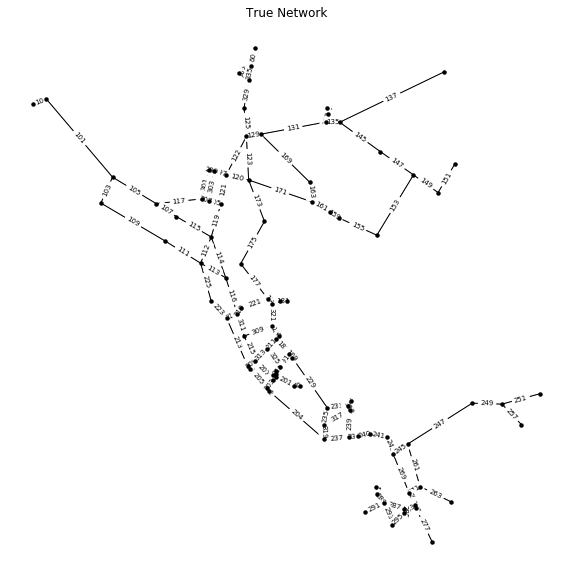

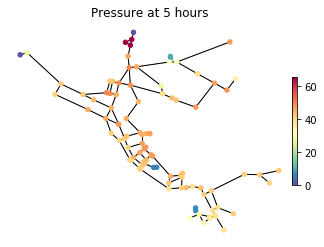

In [31]:
# Set up the known network
inp_file = 'networks/Net3.inp'
wn_true = wntr.network.WaterNetworkModel(inp_file)
waterNetwork = WaterNetworkHelper(wn_true)

# Graph the network
fig,ax = plt.subplots(figsize=(10,10))
wntr.graphics.plot_network(wn_true, title="True Network",link_labels=True,ax=ax)

# Simulate hydraulics
sim_true = wntr.sim.EpanetSimulator(wn_true)
results_true = sim_true.run_sim()

# Plot results on the network
pressure_at_5hr = results_true.node['pressure'].loc[5*3600, :]
wntr.graphics.plot_network(wn_true, node_attribute=pressure_at_5hr, node_size=30, 
                        title='Pressure at 5 hours')

In [26]:
wntr.graphics.plot_leaflet_network(wn_true,filename="testleaflet.html")

# Selecting sensor locations

In [58]:
waterNetwork.nodes

base_demand     coordinates demand  \
name                                       
10       0.000000    (9.0, 27.85)   None   
15       0.000063  (38.68, 23.76)   None   
20       0.000000  (29.44, 26.91)   None   
35       0.000063  (25.46, 10.52)   None   
40       0.000000   (27.02, 9.81)   None   
...           ...             ...    ...   
267      0.000000  (23.38, 12.95)   None   
269      0.000000  (25.03, 12.14)   None   
271      0.000000   (25.97, 11.0)   None   
273      0.000000   (29.16, 7.38)   None   
275      0.000000   (31.07, 8.29)   None   

                                 demand_timeseries_list  elevation  head  \
name                                                                       
10    [<TimeSeries: base=0.0, pattern='1', category=...   44.80560  None   
15    [<TimeSeries: base=6.30901964e-05, pattern='3'...    9.75360  None   
20    [<TimeSeries: base=0.0, pattern='1', category=...   39.31920  None   
35    [<TimeSeries: base=6.30901964e-05, pattern='4'...    3.81000  None   
40    [<TimeSeries: base=0.0, pattern='1', category=...   40.20312  None   
...                                                 ...        ...   ...   
267   [<TimeSeries: base=0.0, pattern='1', category=...    6.40080  None   
269   [<TimeSeries: base=0.0, pattern='1', category=...    0.00000  None   
271   [<TimeSeries: base=0.0, pattern='1', category=...    1.82880  None   
273   [<TimeSeries: base=0.0, pattern='1', category=...    2.43840  None   
275   [<TimeSeries: base=0.0, pattern='1', category=...    3.04800  None   

      initial_quality  leak_area leak_demand  leak_discharge_coeff  \
name                                                                 
10                0.0        0.0        None                   0.0   
15                0.0        0.0        None                   0.0   
20                0.0        0.0        None                   0.0   
35                0.0        0.0        None                   0.0   
40                0.0        0.0        None                   0.0   
...               ...        ...         ...                   ...   
267               0.0        0.0        None                   0.0   
269               0.0        0.0        None                   0.0   
271               0.0        0.0        None                   0.0   
273               0.0        0.0        None                   0.0   
275               0.0        0.0        None                   0.0   

      leak_status  minimum_pressure node_type  nominal_pressure   tag  
name                                                                   
10          False               0.0  Junction              20.0  None  
15          False               0.0  Junction              20.0  None  
20          False               0.0  Junction              20.0  None  
35          False               0.0  Junction              20.0  None  
40          False               0.0  Junction              20.0  None  
...           ...               ...       ...               ...   ...  
267         False               0.0  Junction              20.0  None  
269         False               0.0  Junction              20.0  None  
271         False               0.0  Junction              20.0  None  
273         False               0.0  Junction              20.0  None  
275         False               0.0  Junction              20.0  None  

[92 rows x 15 columns]

In [27]:
waterNetwork.pipes

bulk_rxn_coeff     cv  diameter end_node end_node_name  flow  \
name                                                                
20             None  False    2.5146       20            20  None   
40             None  False    2.5146       40            40  None   
50             None  False    2.5146       50            50  None   
60             None  False    0.6096       60            60  None   
101            None  False    0.4572      101           101  None   
...             ...    ...       ...      ...           ...   ...   
323            None  False    0.3048      275           275  None   
325            None  False    0.2032      271           271  None   
329            None  False    0.7620      123           123  None   
330            None  False    0.7620      601           601  None   
333            None  False    0.7620       61            61  None   

     initial_setting  initial_status      length link_type  ...  \
name                                                        ...   
20              None               1     30.1752      Pipe  ...   
40              None               1     30.1752      Pipe  ...   
50              None               1     30.1752      Pipe  ...   
60              None               1    375.2088      Pipe  ...   
101             None               1   4328.1600      Pipe  ...   
...              ...             ...         ...       ...  ...   
323             None               1     91.4400      Pipe  ...   
325             None               1    393.1920      Pipe  ...   
329             None               1  13868.4000      Pipe  ...   
330             None               0      0.3048      Pipe  ...   
333             None               1      0.3048      Pipe  ...   

      end_node_current_flow_betweenness_centrality  \
name                                                 
20                                        0.020833   
40                                        0.020833   
50                                        0.020833   
60                                        0.027705   
101                                       0.106898   
...                                            ...   
323                                       0.184970   
325                                       0.136291   
329                                       0.080702   
330                                       0.013743   
333                                       0.061330   

      start_node_vote_rank_order end_node_vote_rank_order  \
name                                                        
20                            96                       40   
40                            94                       20   
50                            95                       36   
60                            92                        6   
101                           35                        7   
...                          ...                      ...   
323                           26                       91   
325                           89                       49   
329                           29                       58   
330                            6                       52   
333                           52                       29   

     start_node_degree_load_centrality end_node_degree_load_centrality  \
name                                                                     
20                            0.000000                        0.000548   
40                            0.000000                        0.002851   
50                            0.000000                        0.000329   
60                            0.000000                        0.008114   
101                           0.004825                        0.009430   
...                                ...                             ...   
323                           0.014967                        0.026480   
325                           0.002851                        0.005866  

In [28]:
df_pipeStatistics = waterNetwork.pipes[["diameter","highest_node_degree","highest_node_current_flow_betweenness_centrality","highest_node_vote_rank_order","highest_node_degree_load_centrality"]]
df_pipeStatistics.columns = ["Diameter","Degree","Current Flow Betweenness Centrality","Vote Rank Order","Degree Load Centrality"]

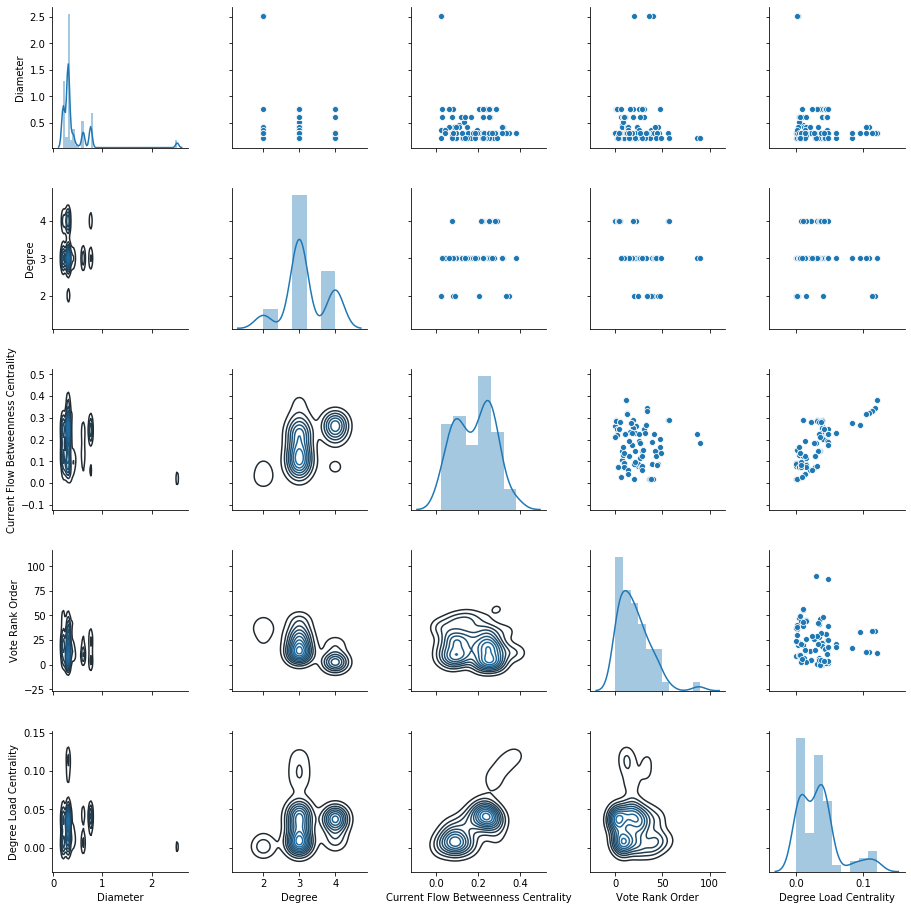

In [29]:
g = sns.PairGrid(df_pipeStatistics, diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)
g.map_diag(sns.distplot)

In [30]:
df_pipeStatistics = waterNetwork.pipes[["diameter","highest_node_current_flow_betweenness_centrality","highest_node_vote_rank_order","highest_node_degree_load_centrality"]]
df_pipeStatistics.columns = ["Diameter","Current Flow Betweenness Centrality","Vote Rank Order","Degree Load Centrality"]

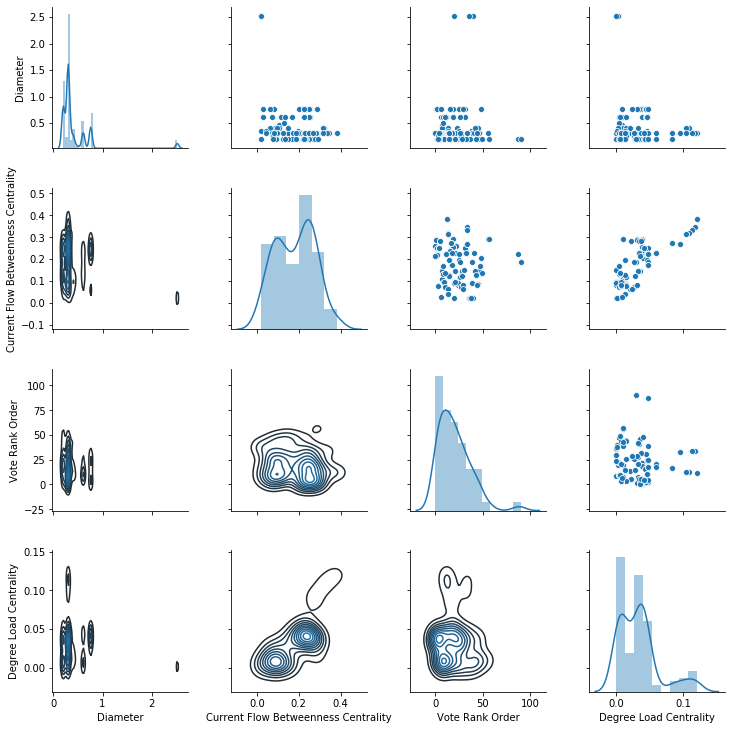

In [31]:
g = sns.PairGrid(df_pipeStatistics, diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)
g.map_diag(sns.distplot)

# Generate candidate lists of sensors based upon network statistics

In [28]:
nHighest = 15

## Set sensors based on n-highest vote ranks

In [31]:
wn_true = wntr.network.WaterNetworkModel(inp_file)
waterNetwork = WaterNetworkHelper(wn_true)
listOfCalibrators = generateListOfCalibrators(waterNetwork,["204","225","229","173"],calibrationParameter="roughness",calibratorSTD=30)

In [32]:
pipesToSense = list(waterNetwork.pipes.sort_values("highest_node_vote_rank_order").iloc[0:nHighest].index)
listOfSensors = generateListOfSensors(waterNetwork,pipesToSense)

In [33]:
results_VoteRank = MCMC(waterNetwork,listOfCalibrators,listOfSensors,nIterations=5000)
acceptanceRate = np.sum(results_VoteRank["isAccepted"])/len(results_VoteRank["isAccepted"])
savePickle(results_VoteRank,"results_VoteRank_15.pkl")

 [████████████████████████████████████████████████████████████] 5000/5000 [25:22<00:00, 0.30s/it]

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning:

divide by zero encountered in log

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning:

overflow encountered in exp



(<matplotlib.axes._subplots.AxesSubplot at 0x1886461b508>,
 <matplotlib.axes._subplots.AxesSubplot at 0x188644a37c8>)

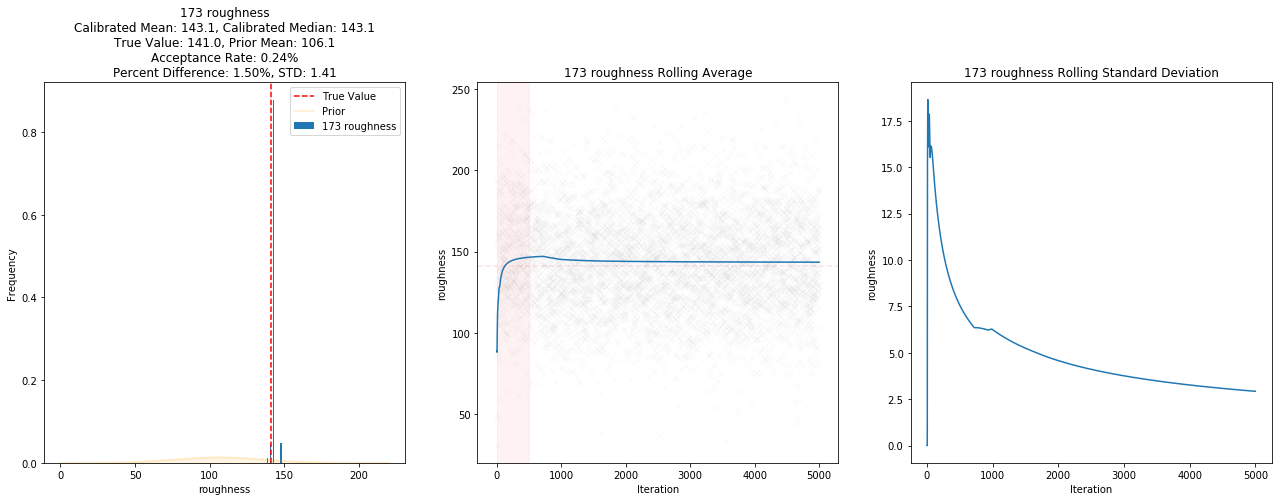

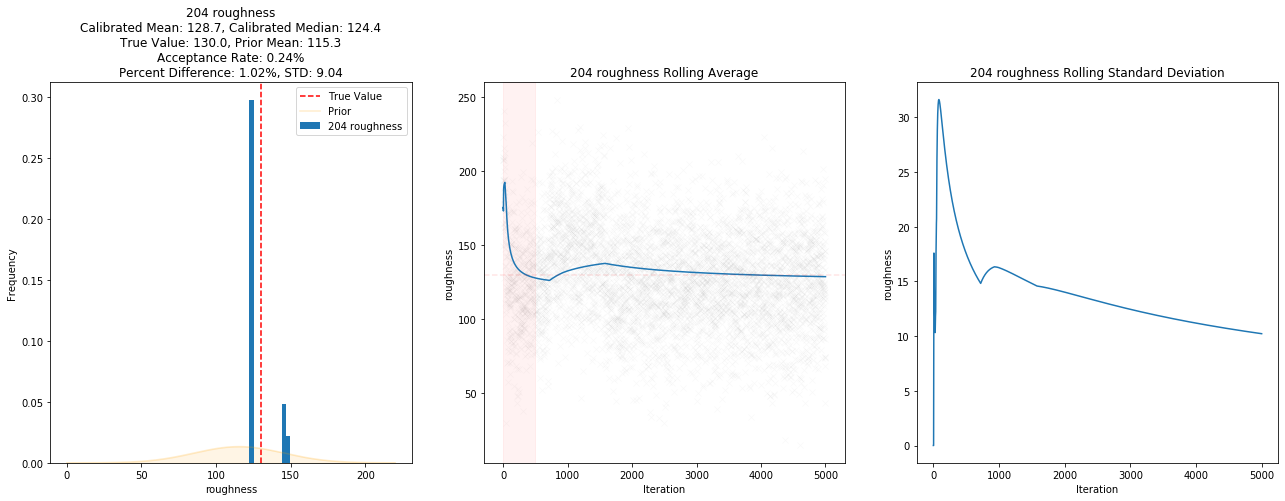

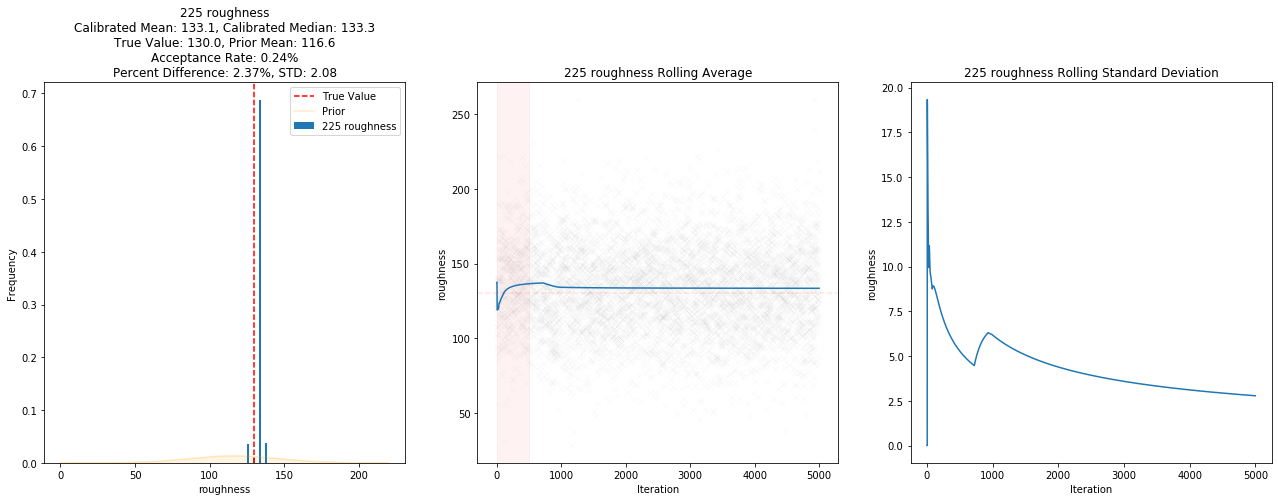

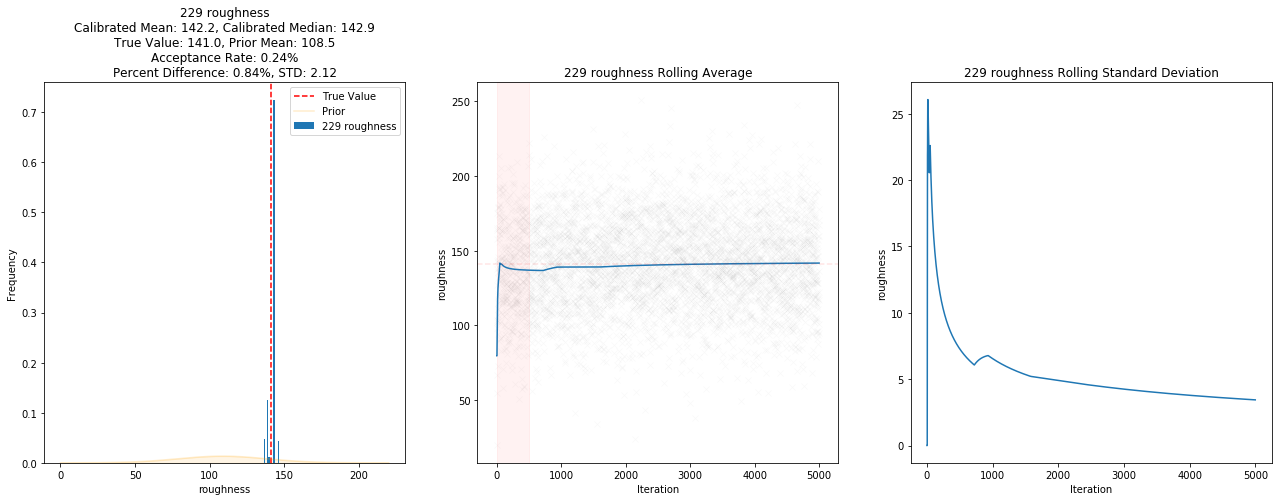

In [36]:
plotCalibratorResults(listOfCalibrators,burnin=0.1,acceptanceRate=acceptanceRate,pointAlpha=0.05)

(<matplotlib.axes._subplots.AxesSubplot at 0x1b564d42248>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1b564d5d888>)

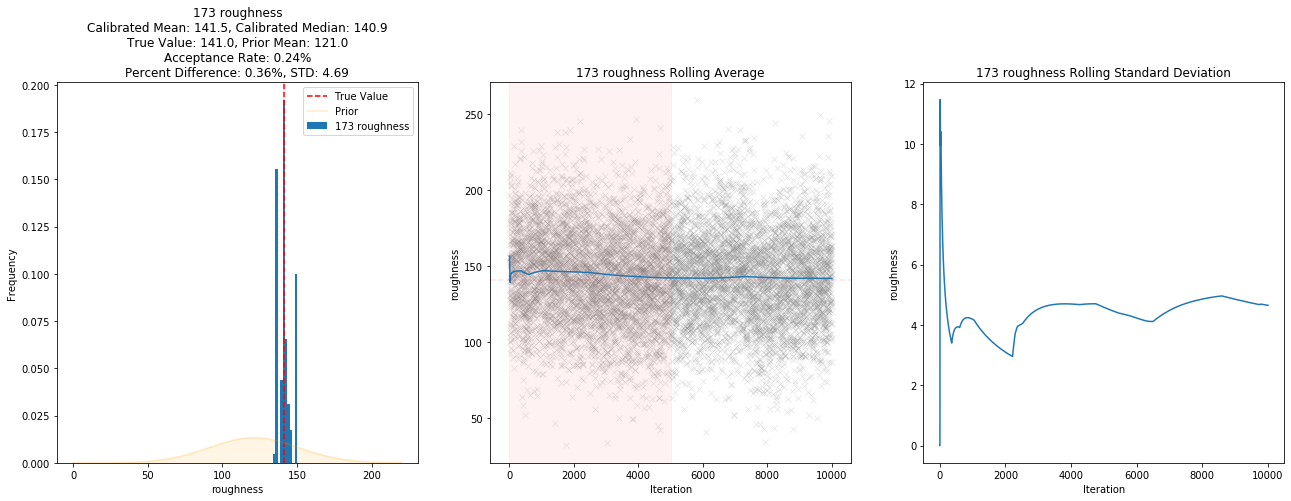

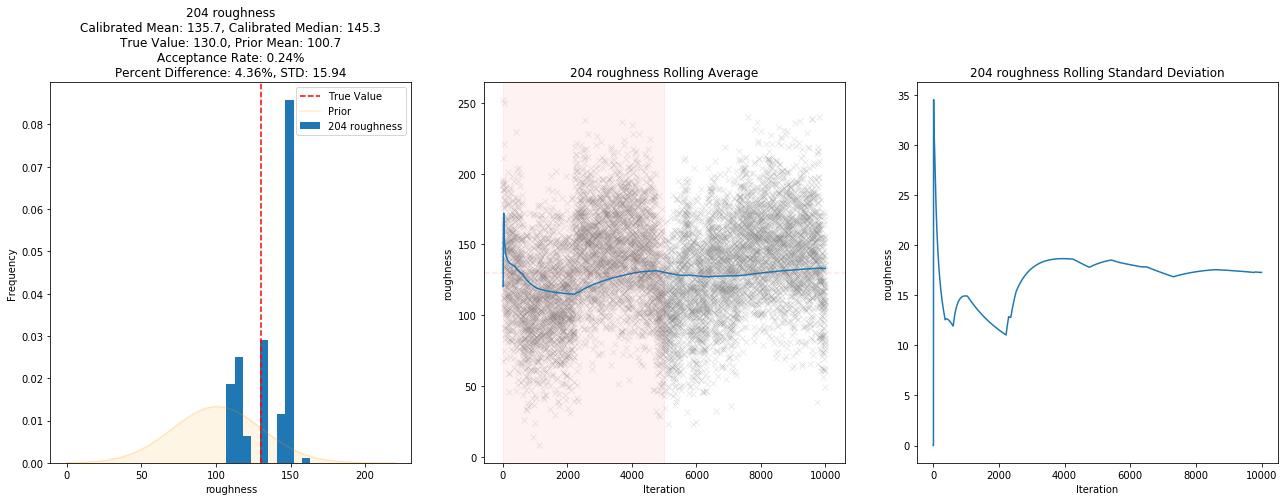

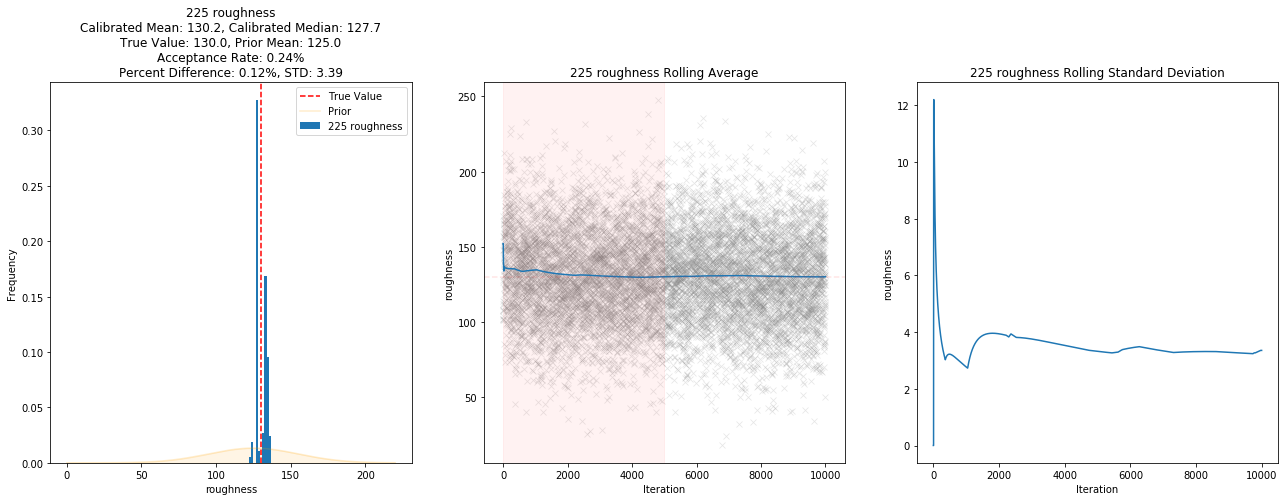

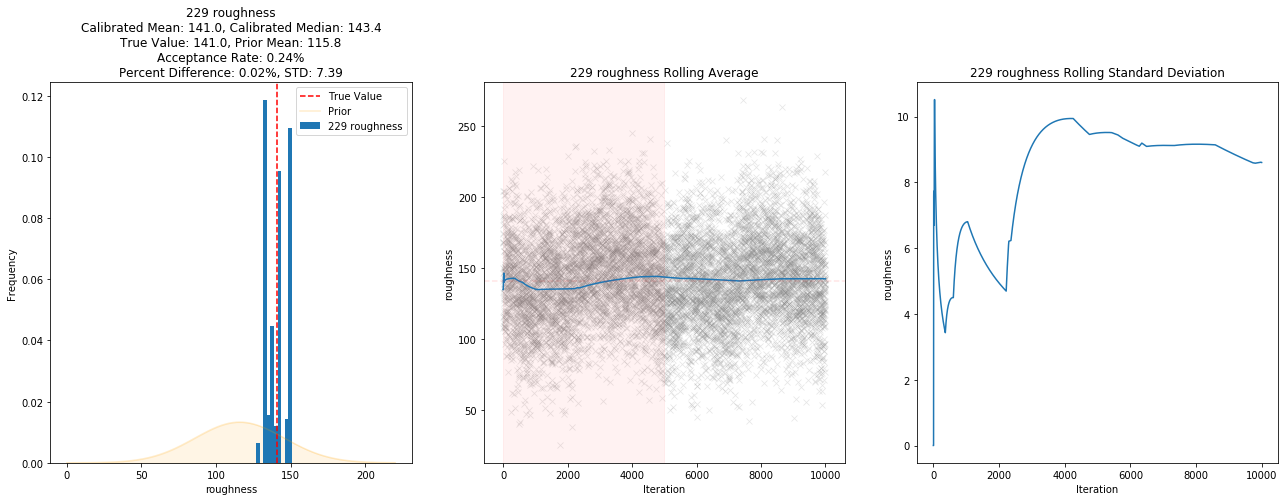

In [36]:
plotCalibratorResults(listOfCalibrators,burnin=0.5,acceptanceRate=acceptanceRate)

## Set sensors on largest pipes

In [38]:
wn_true = wntr.network.WaterNetworkModel(inp_file)
waterNetwork = WaterNetworkHelper(wn_true)
listOfCalibrators = generateListOfCalibrators(waterNetwork,["204","225","229","173"],calibrationParameter="roughness",calibratorSTD=30)
waterNetwork.generateNetworkStatistics()

In [44]:
pipesToSense = list(waterNetwork.pipes.sort_values("diameter",ascending=False).iloc[0:nHighest].index)

In [45]:
listOfSensors = generateListOfSensors(waterNetwork,pipesToSense)

In [46]:
results_largestPipes = MCMC(waterNetwork,listOfCalibrators,listOfSensors,nIterations=5000)
acceptanceRate = np.sum(results_largestPipes["isAccepted"])/len(results_largestPipes["isAccepted"])
savePickle(results_largestPipes,"results_largestPipes.pkl")

 [████████████████████████████████████████████████████████████] 5000/5000 [29:25<00:00, 0.35s/it]

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning:

divide by zero encountered in log

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning:

overflow encountered in exp



(<matplotlib.axes._subplots.AxesSubplot at 0x18866b68f08>,
 <matplotlib.axes._subplots.AxesSubplot at 0x188649626c8>)

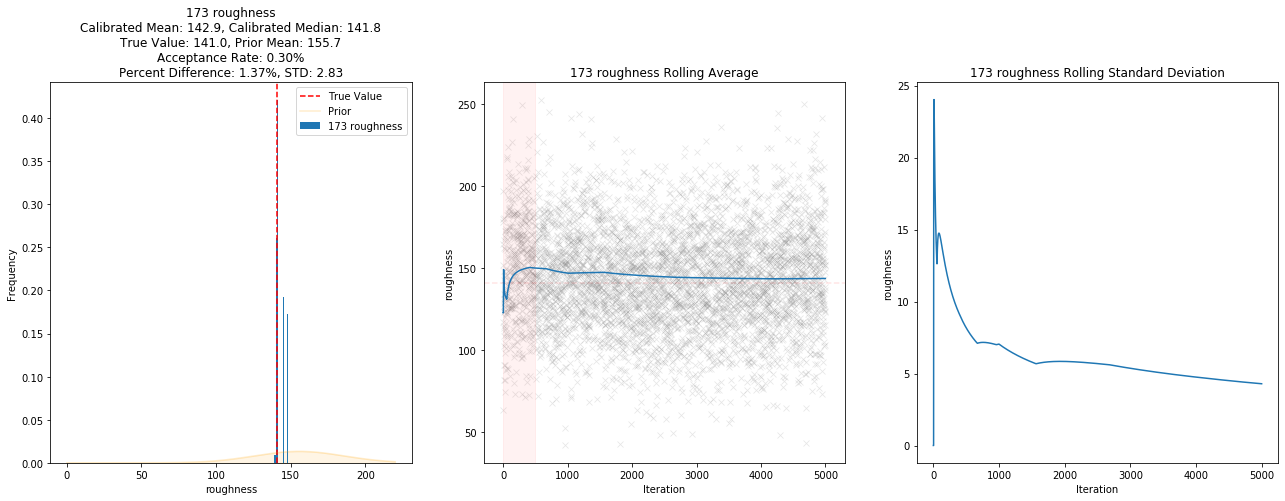

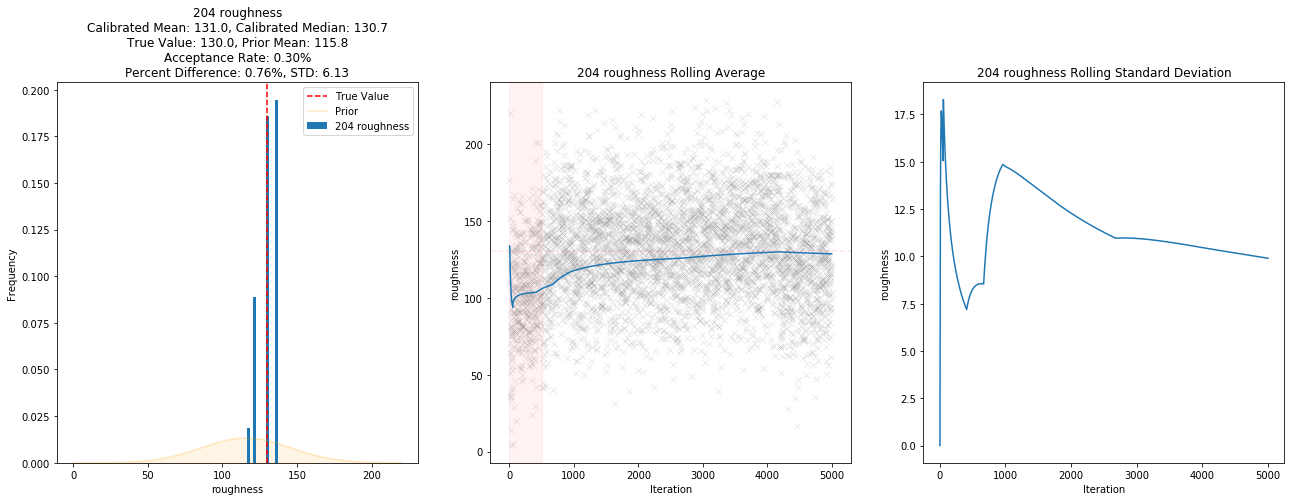

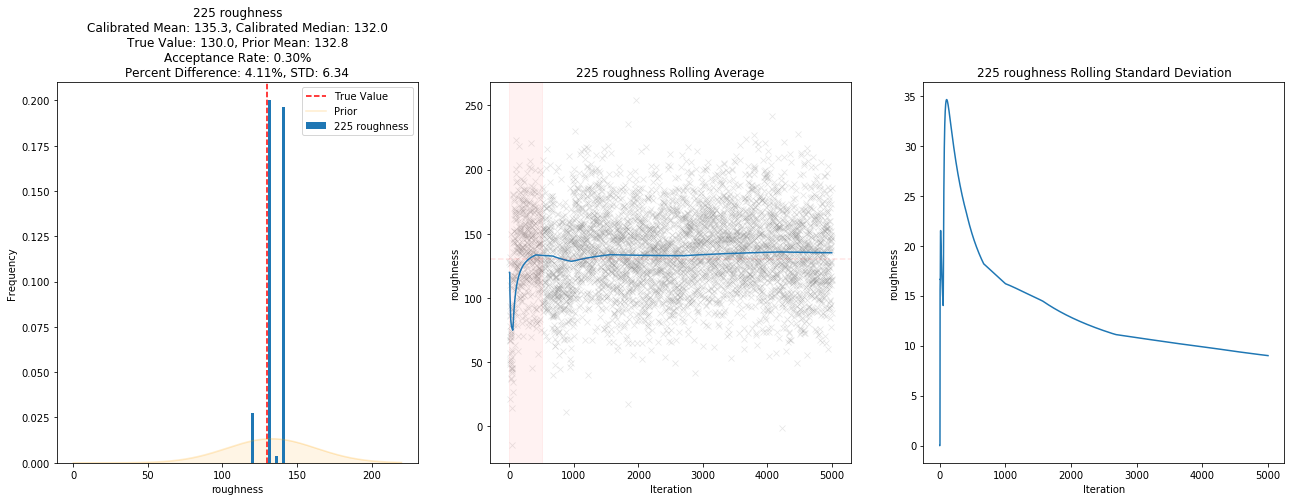

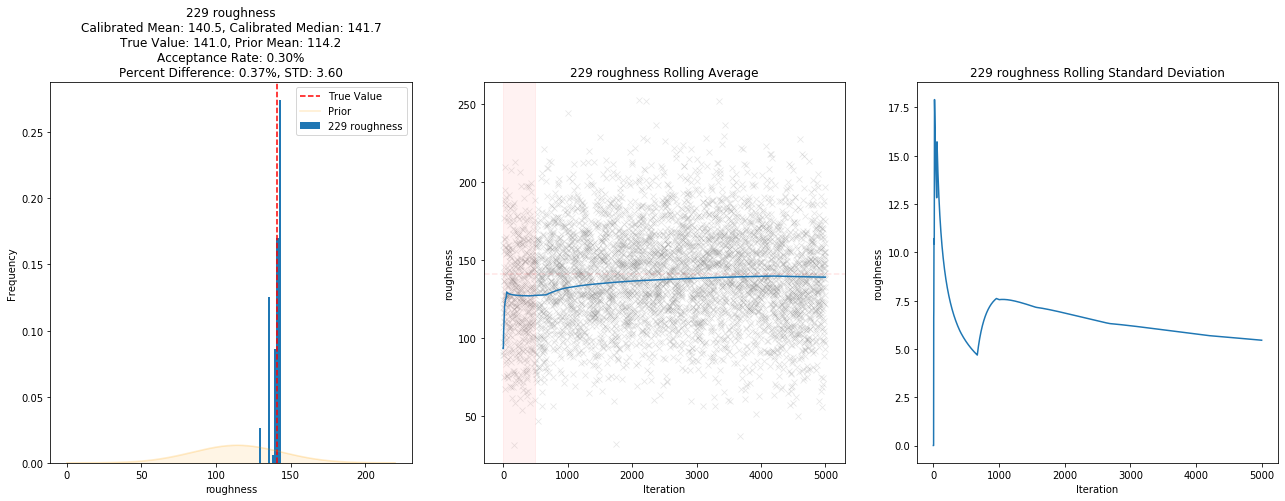

In [48]:
plotCalibratorResults(listOfCalibrators,burnin=0.1,acceptanceRate=acceptanceRate)

## Set sensors based on highest node degree

In [54]:
wn_true = wntr.network.WaterNetworkModel(inp_file)
waterNetwork = WaterNetworkHelper(wn_true)
listOfCalibrators = generateListOfCalibrators(waterNetwork,["204","225","229","173"],calibrationParameter="roughness",calibratorSTD=30)

In [55]:
waterNetwork.generateNetworkStatistics()
pipesToSense = list(waterNetwork.pipes.sort_values("highest_node_degree").iloc[0:nHighest].index)
listOfSensors = generateListOfSensors(waterNetwork,pipesToSense)

In [56]:
results_NodeDegree = MCMC(waterNetwork,listOfCalibrators,listOfSensors,nIterations=10000)
acceptanceRate = np.sum(results_NodeDegree["isAccepted"])/len(results_NodeDegree["isAccepted"])
savePickle(results_NodeDegree,"results_NodeDegree.pkl")

 [████████████████████████████████████████████████████████████] 10000/10000 [50:01<00:00, 0.30s/it]

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning:

overflow encountered in exp

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning:

divide by zero encountered in log



(<matplotlib.axes._subplots.AxesSubplot at 0x18864879988>,
 <matplotlib.axes._subplots.AxesSubplot at 0x188e5e53248>)

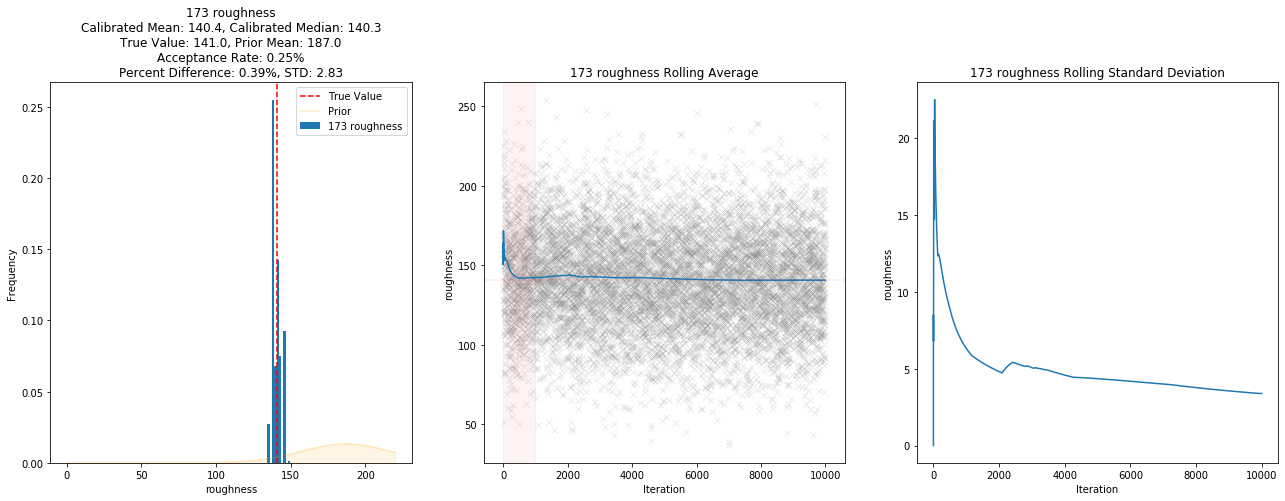

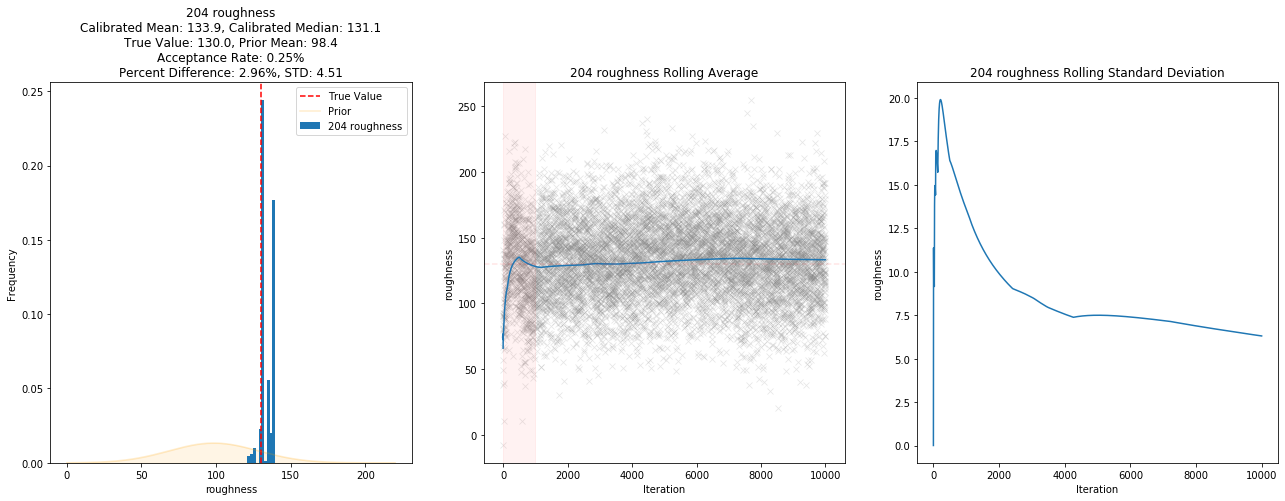

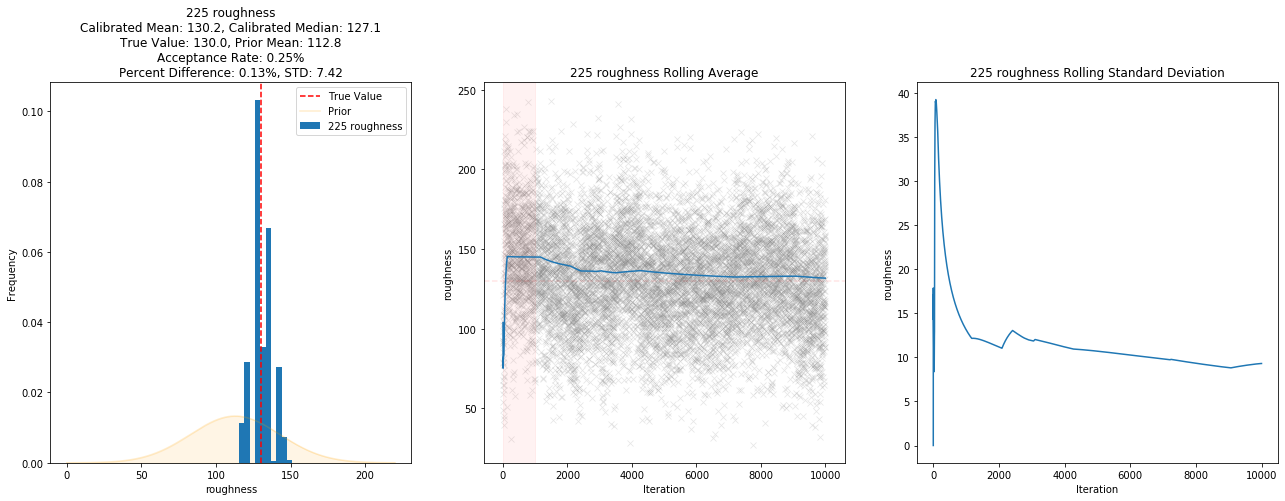

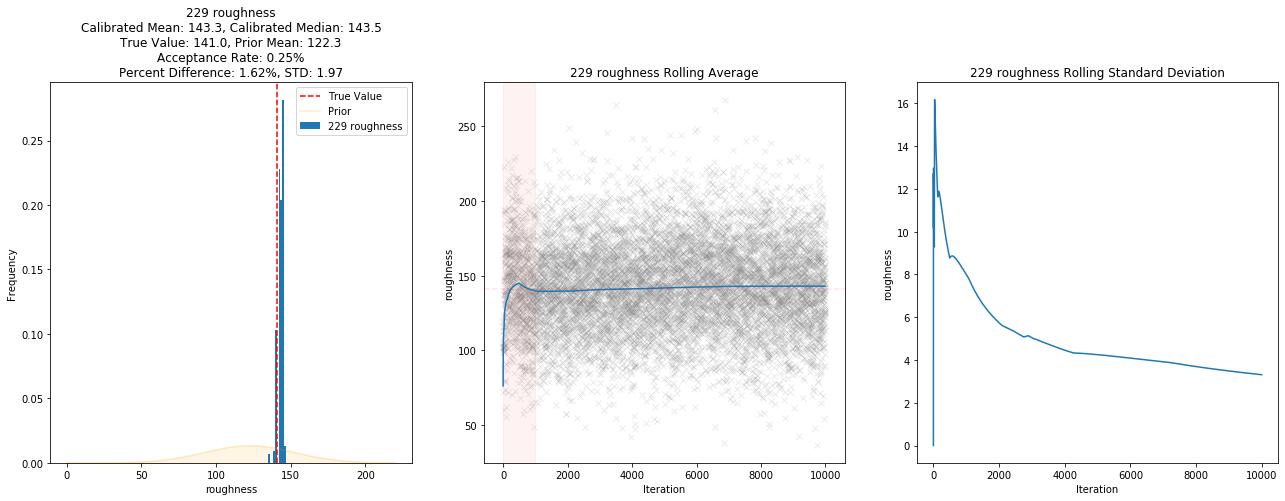

In [57]:
plotCalibratorResults(listOfCalibrators,burnin=0.1,acceptanceRate=acceptanceRate)

## Set sensors based on highest node degree centrality

In [75]:
wn_true = wntr.network.WaterNetworkModel(inp_file)
waterNetwork = WaterNetworkHelper(wn_true)
listOfCalibrators = generateListOfCalibrators(waterNetwork,["204","225","229","173"],calibrationParameter="roughness",calibratorSTD=30)

In [76]:
waterNetwork.generateNetworkStatistics()
pipesToSense = list(waterNetwork.pipes.sort_values("highest_node_current_flow_betweenness_centrality").iloc[0:nHighest].index)
listOfSensors = generateListOfSensors(waterNetwork,pipesToSense)

In [77]:
results_NodeDegreeCentrality = MCMC(waterNetwork,listOfCalibrators,listOfSensors,nIterations=2500)
acceptanceRate = np.sum(results_NodeDegreeCentrality["isAccepted"])/len(results_NodeDegreeCentrality["isAccepted"])
savePickle(results_NodeDegreeCentrality,"results_NodeDegreeCentrality.pkl")

 [████████████████████████████████████████████████████████████] 2500/2500 [03:59<00:00, 0.10s/it]

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning:

divide by zero encountered in log

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning:

overflow encountered in exp



(<matplotlib.axes._subplots.AxesSubplot at 0x17ca1eb5788>,
 <matplotlib.axes._subplots.AxesSubplot at 0x17ca1f7c508>)

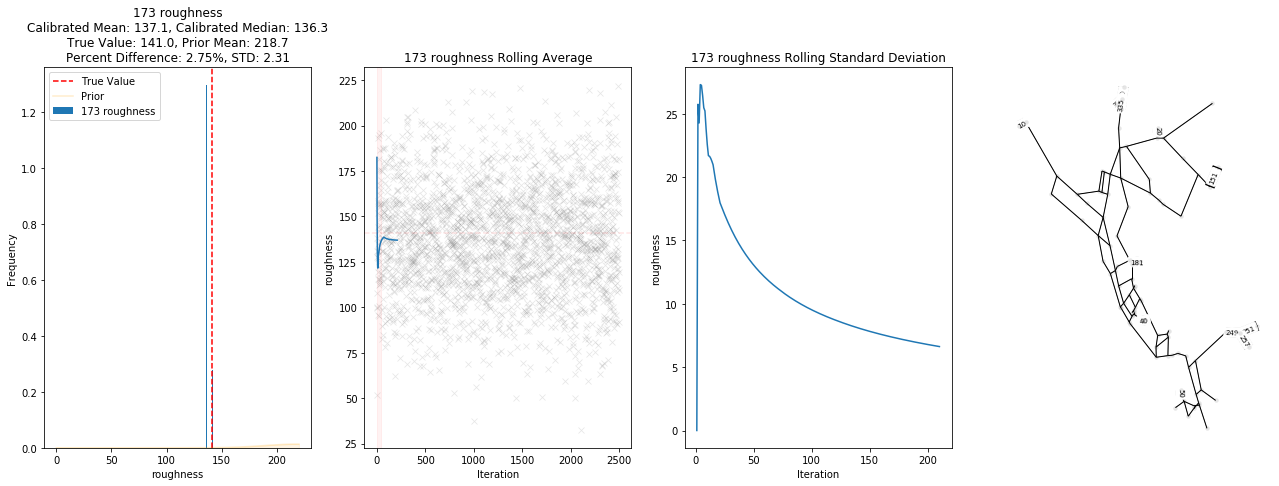

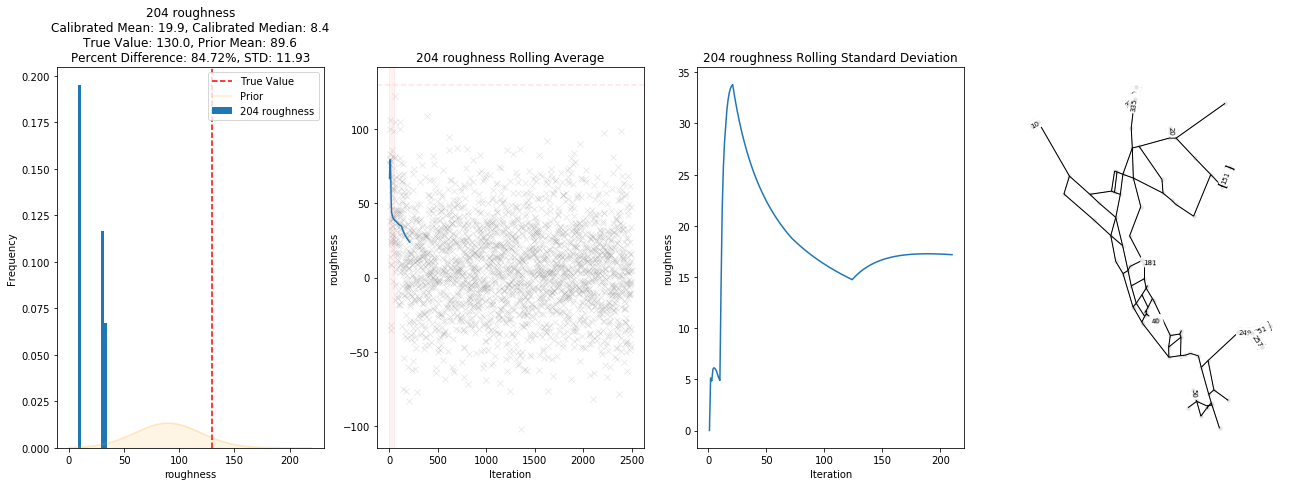

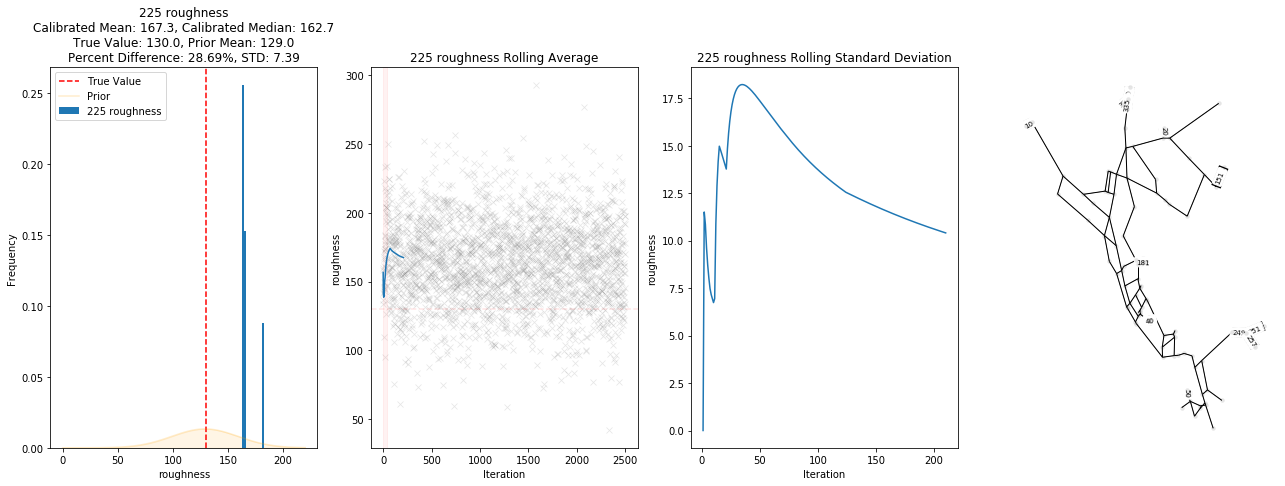

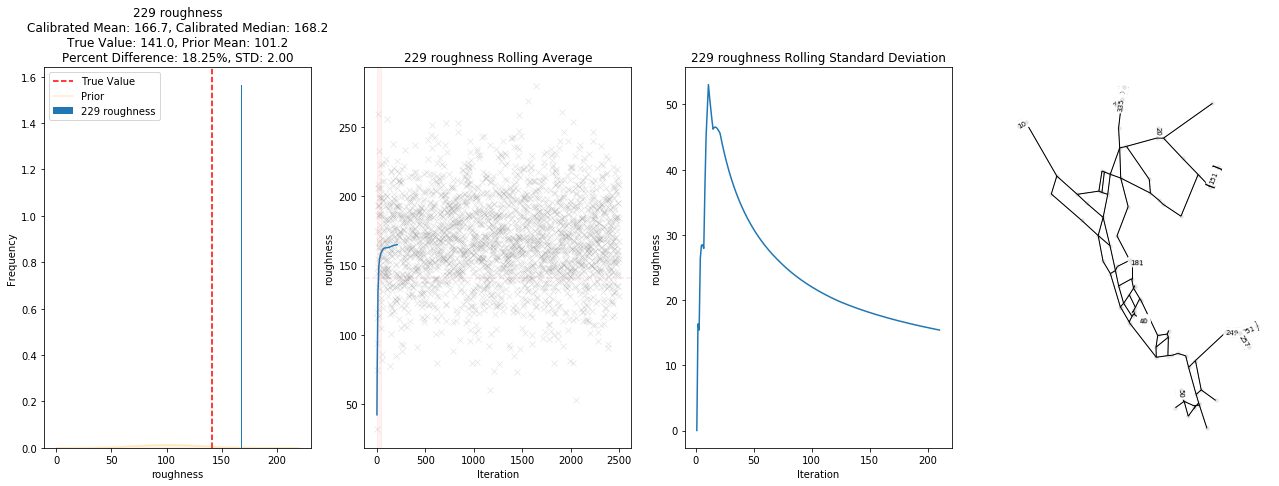

In [85]:
plotCalibratorResults_WithMap(results_NodeDegreeCentrality)

(<matplotlib.axes._subplots.AxesSubplot at 0x17c12bc6448>,
 <matplotlib.axes._subplots.AxesSubplot at 0x17c09e24748>)

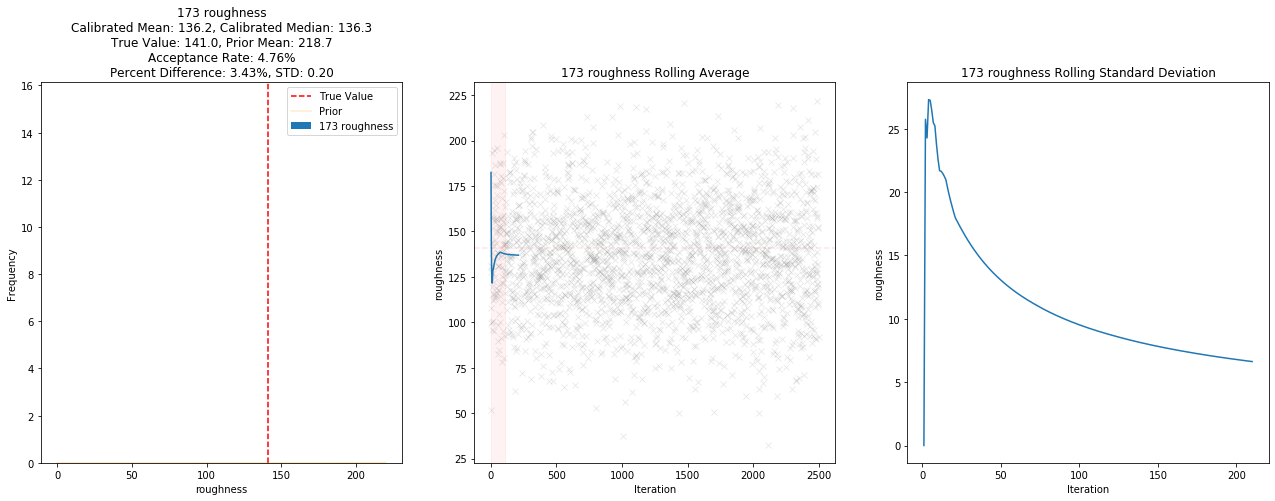

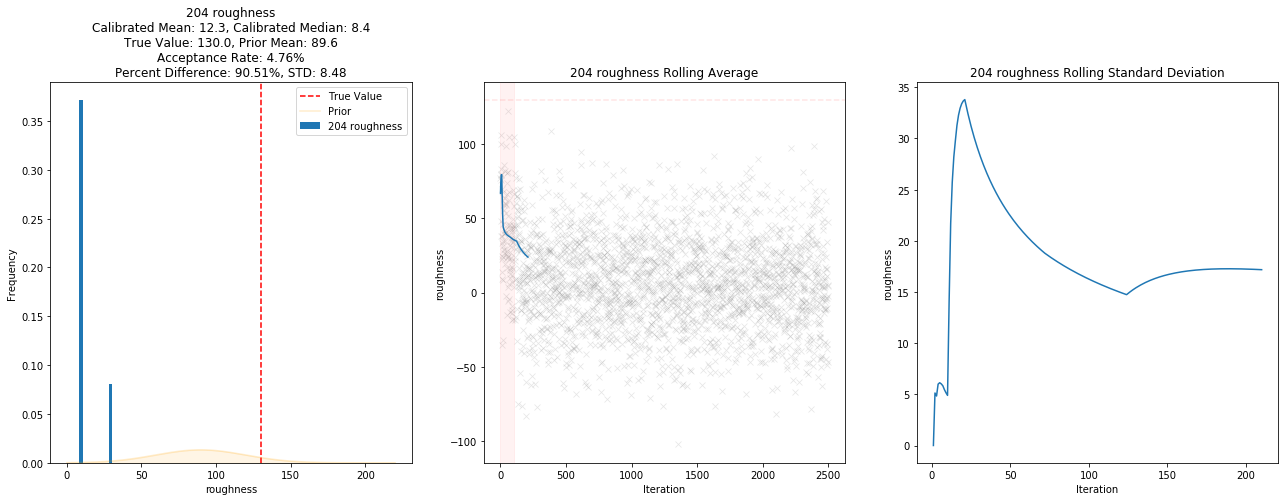

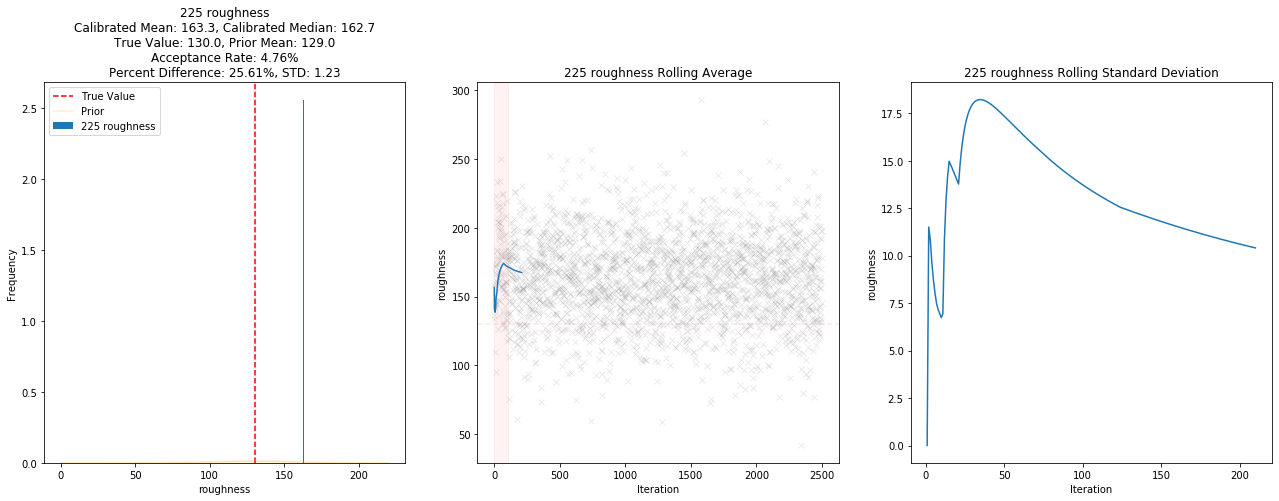

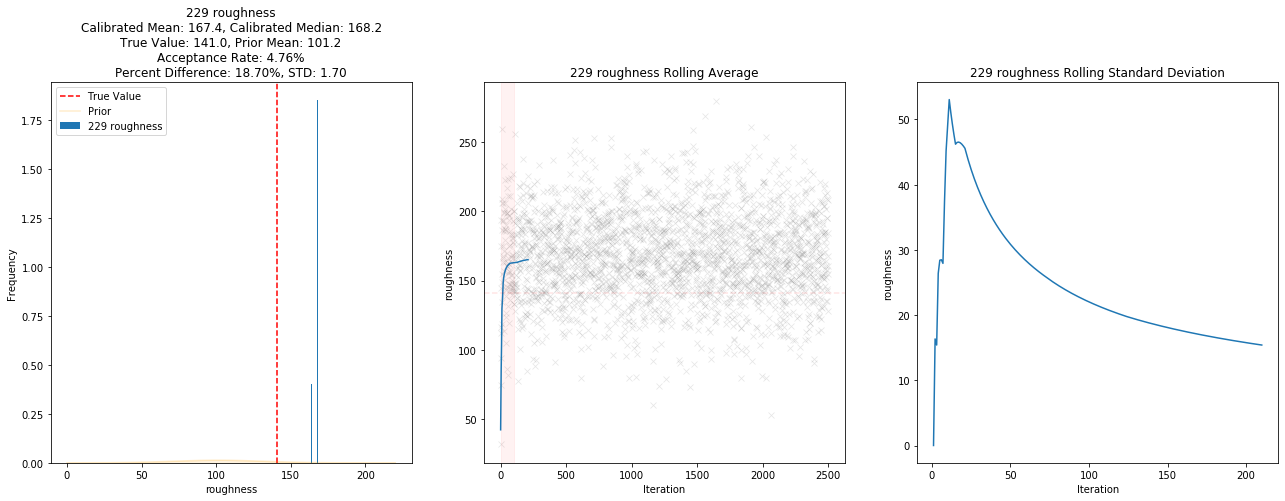

In [78]:
plotCalibratorResults(listOfCalibrators,burnin=0.5,acceptanceRate=acceptanceRate)

## Bridges

In [49]:
wn_true = wntr.network.WaterNetworkModel(inp_file)
waterNetwork = WaterNetworkHelper(wn_true)
listOfCalibrators = generateListOfCalibrators(waterNetwork,["204","225","229","173"],calibrationParameter="roughness",calibratorSTD=30)

In [50]:
waterNetwork.generateNetworkStatistics()
pipesToSense = list(waterNetwork.pipes[waterNetwork.pipes["link_is_bridge"]].index)

In [51]:
listOfSensors = generateListOfSensors(waterNetwork,pipesToSense)

In [52]:
results_bridges = MCMC(waterNetwork,listOfCalibrators,listOfSensors,nIterations=5000)
acceptanceRate = np.sum(results_bridges["isAccepted"])/len(results_bridges["isAccepted"])
savePickle(results_bridges,"results_bridges.pkl")

 [████████████████████████████████████████████████████████████] 5000/5000 [37:38<00:00, 0.45s/it]

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning:

divide by zero encountered in log

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning:

overflow encountered in exp



(<matplotlib.axes._subplots.AxesSubplot at 0x18865cd71c8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x188e6ff7348>)

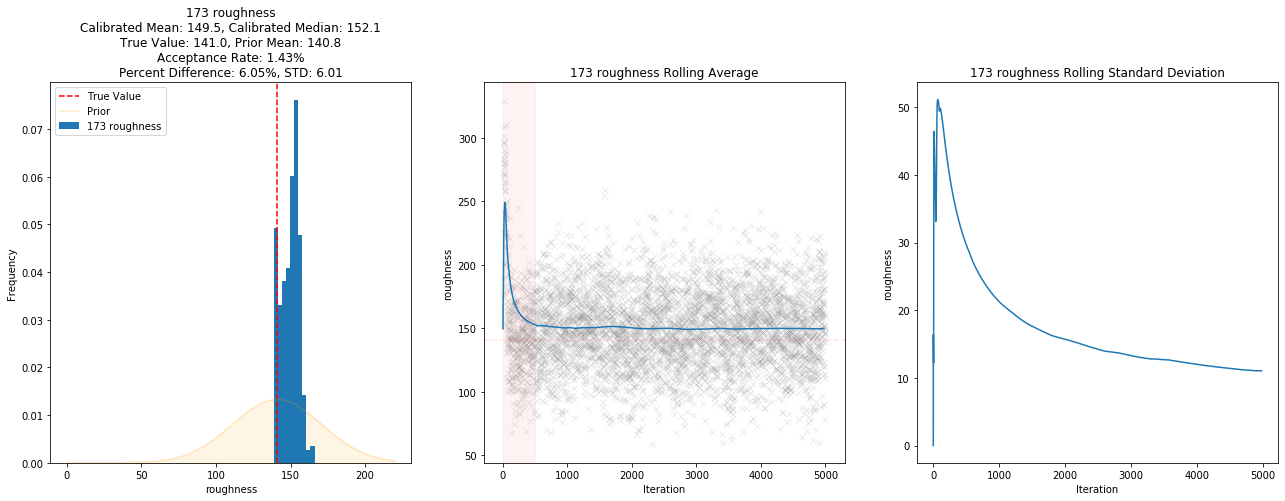

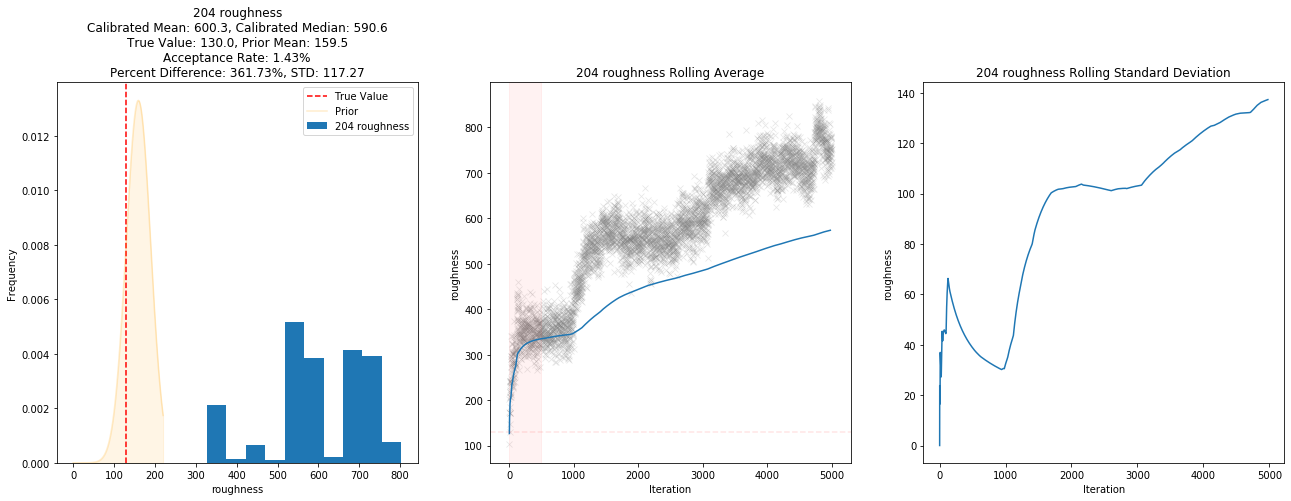

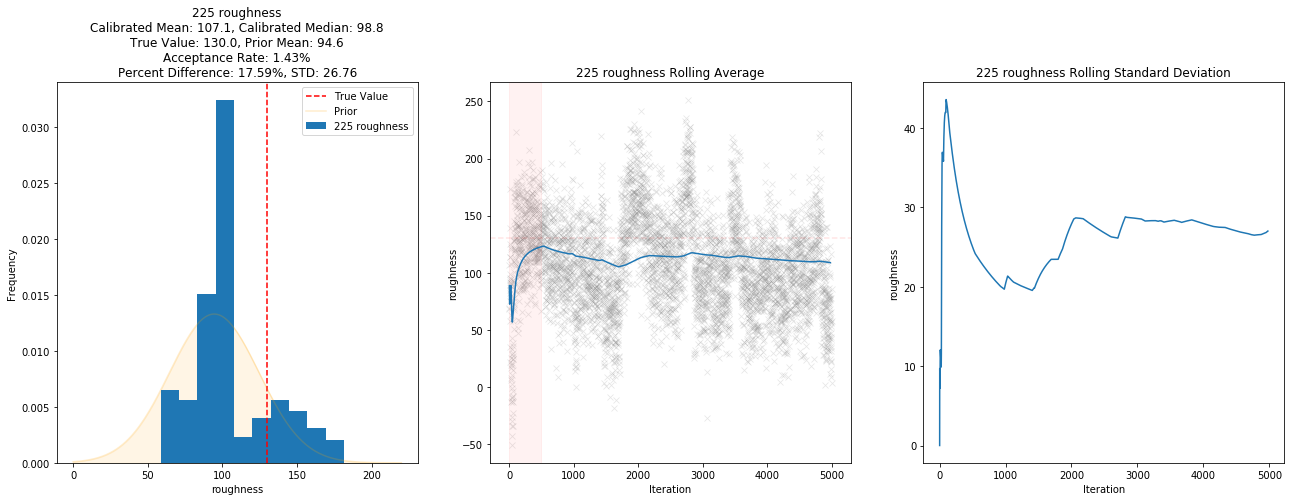

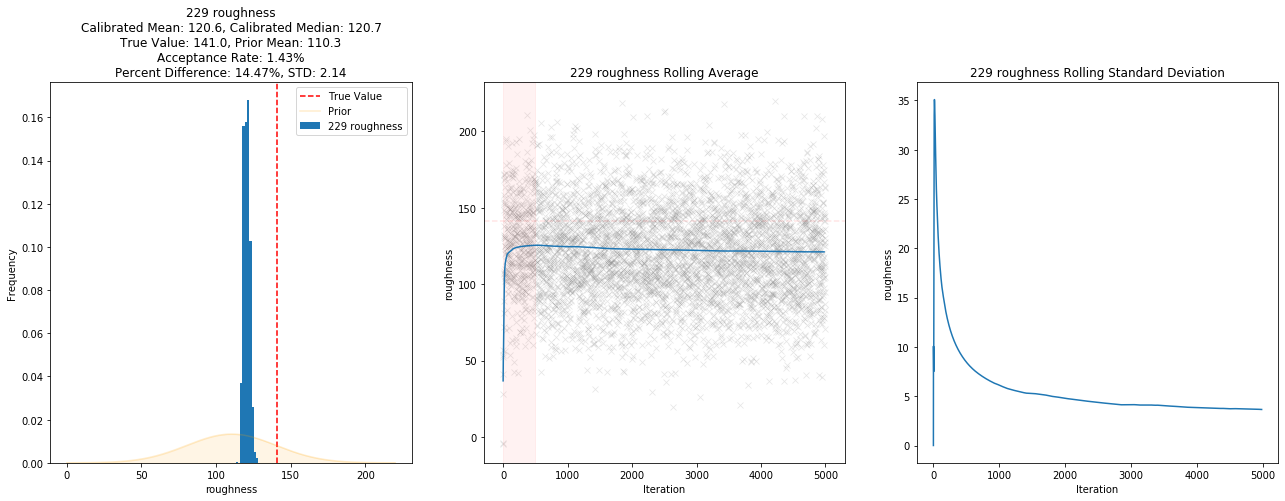

In [53]:
plotCalibratorResults(listOfCalibrators,burnin=0.1,acceptanceRate=acceptanceRate)

# Generate candidate lists of sensors based upon calibrator locations

## Set sensors at each calibrator

In [37]:
wn_true = wntr.network.WaterNetworkModel(inp_file)
waterNetwork = WaterNetworkHelper(wn_true)
listOfCalibrators = generateListOfCalibrators(waterNetwork,["204","225","229","173"],calibrationParameter="roughness",calibratorSTD=30)

In [38]:
pipesToSense = ["204","225","229","173"]
listOfSensors = generateListOfSensors(waterNetwork,pipesToSense)

In [39]:
results_SenseCalibrators = MCMC(waterNetwork,listOfCalibrators,listOfSensors,nIterations=2000)
acceptanceRate = np.sum(results_SenseCalibrators["isAccepted"])/len(results_SenseCalibrators["isAccepted"])
savePickle(results_SenseCalibrators,"results_SenseCalibrators.pkl")

 [████████████████████████████████████████████████████████████] 2000/2000 [07:53<00:00, 0.24s/it]

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning:

overflow encountered in exp

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning:

divide by zero encountered in log



(<matplotlib.axes._subplots.AxesSubplot at 0x17c08c0d148>,
 <matplotlib.axes._subplots.AxesSubplot at 0x17c08c75048>)

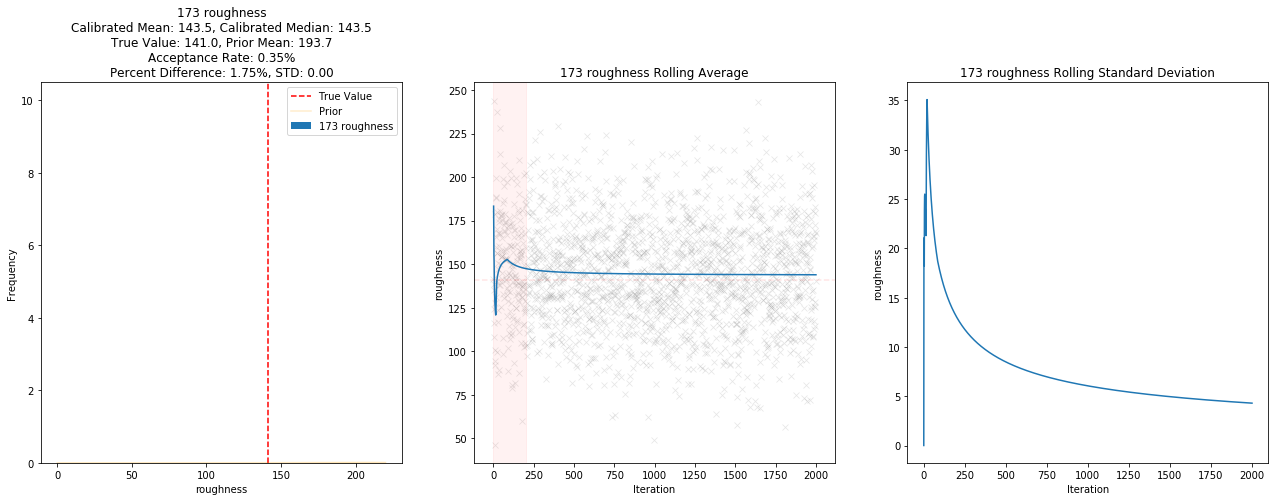

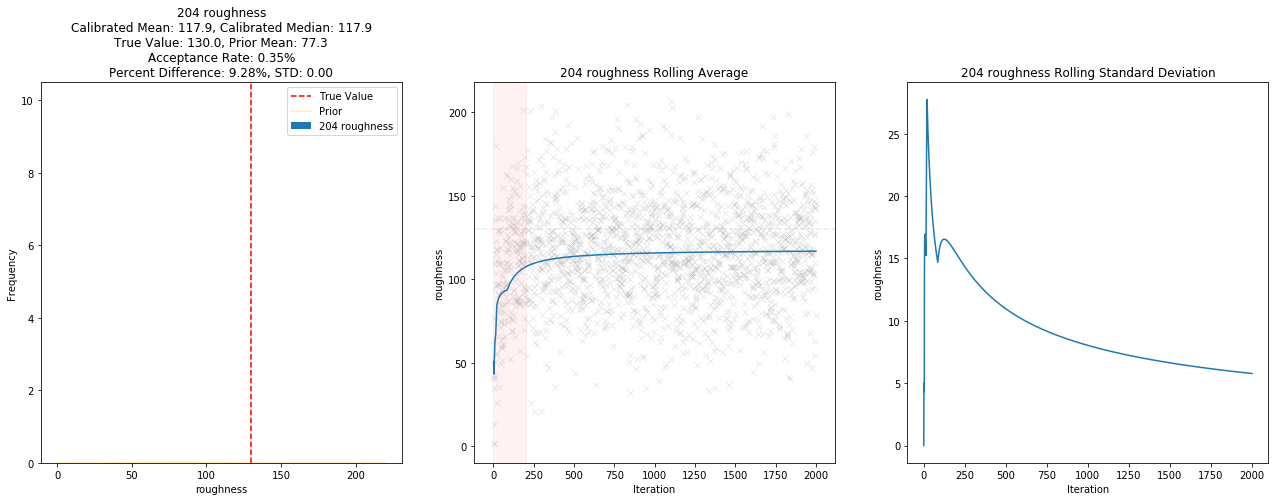

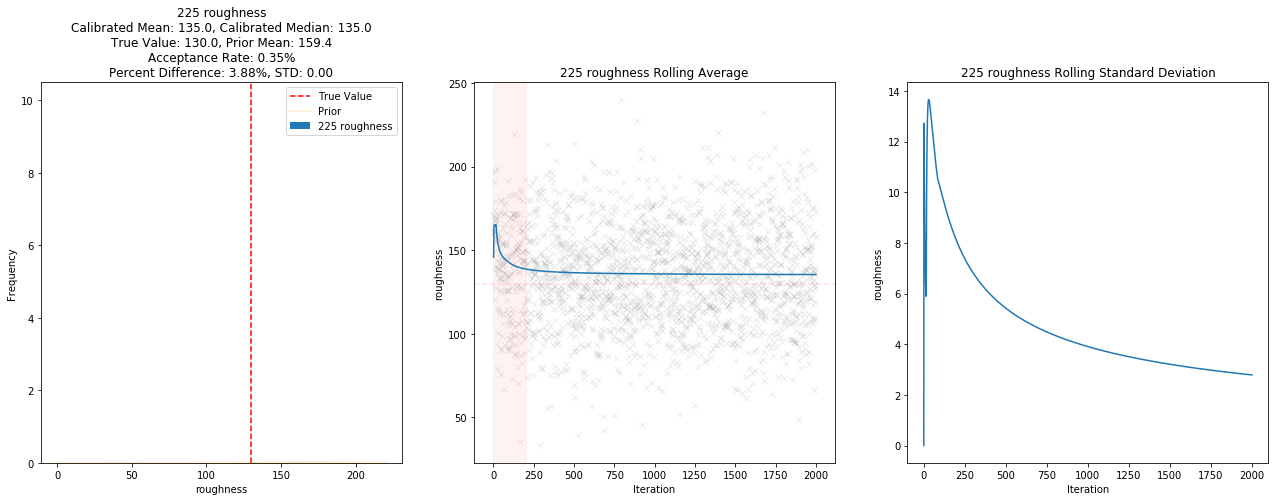

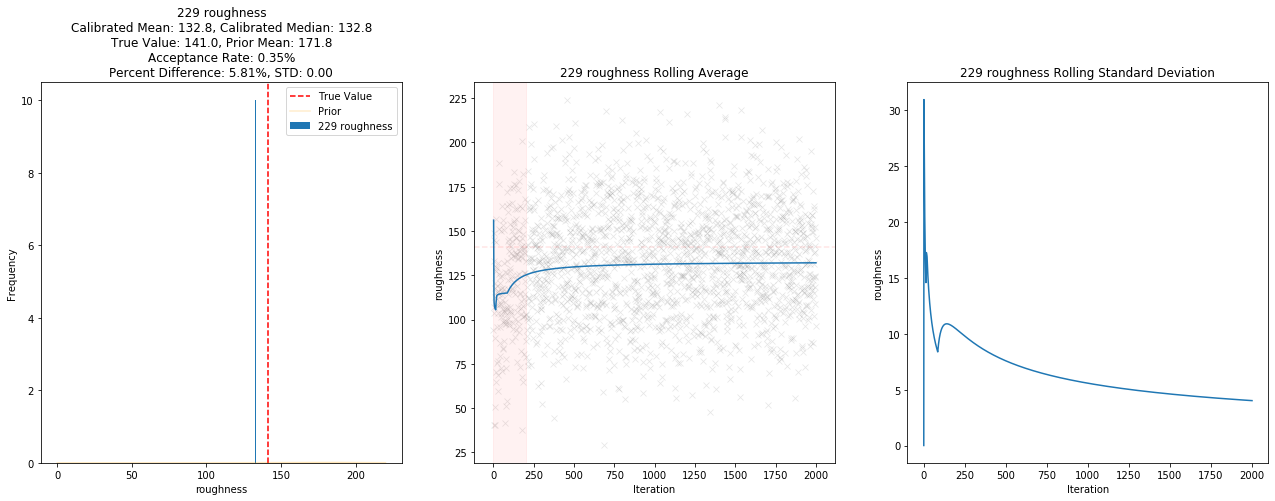

In [41]:
plotCalibratorResults(listOfCalibrators,burnin=0.1,acceptanceRate=acceptanceRate)

# Markov Chain Monte Carlo

In [40]:
listOfSensors = generateListOfSensors(waterNetwork,["205","120","269","149"])

In [41]:
listOfCalibrators = generateListOfCalibrators(waterNetwork,["204","225","229","173"],calibrationParameter="roughness",calibratorSTD=30)
# listOfSensors = generateRandomSensors(waterNetwork)

In [42]:
resultsDict = MCMC(waterNetwork,listOfCalibrators,listOfSensors,nIterations=10000)

 [████████████████████████████████████████████████████████████] 10000/10000 [40:01<00:00, 0.24s/it]

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning:

divide by zero encountered in log



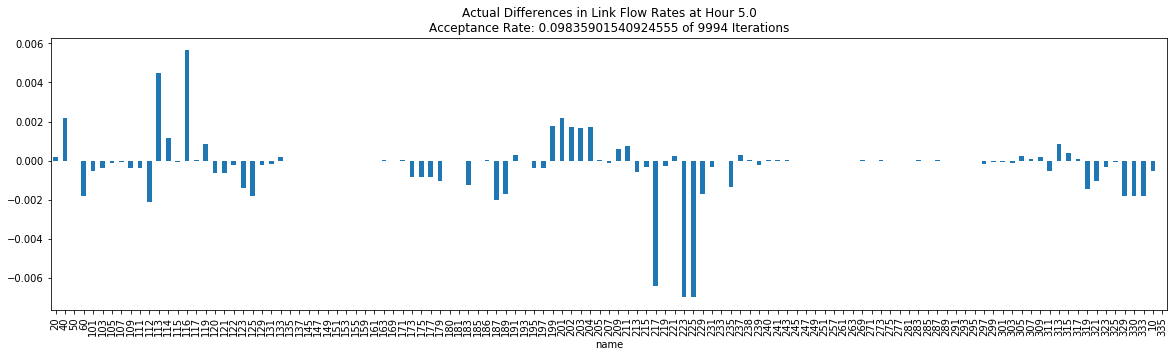

In [43]:
plotDifferencesInResults(resultsDict)

(<matplotlib.axes._subplots.AxesSubplot at 0x22d269f3f48>,
 <matplotlib.axes._subplots.AxesSubplot at 0x22d26a1b3c8>)

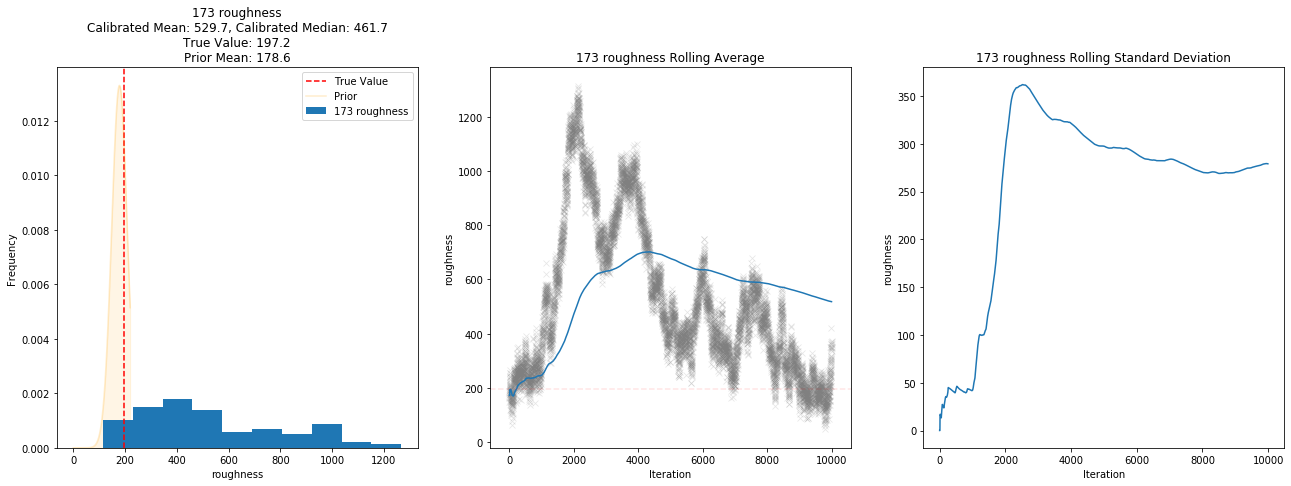

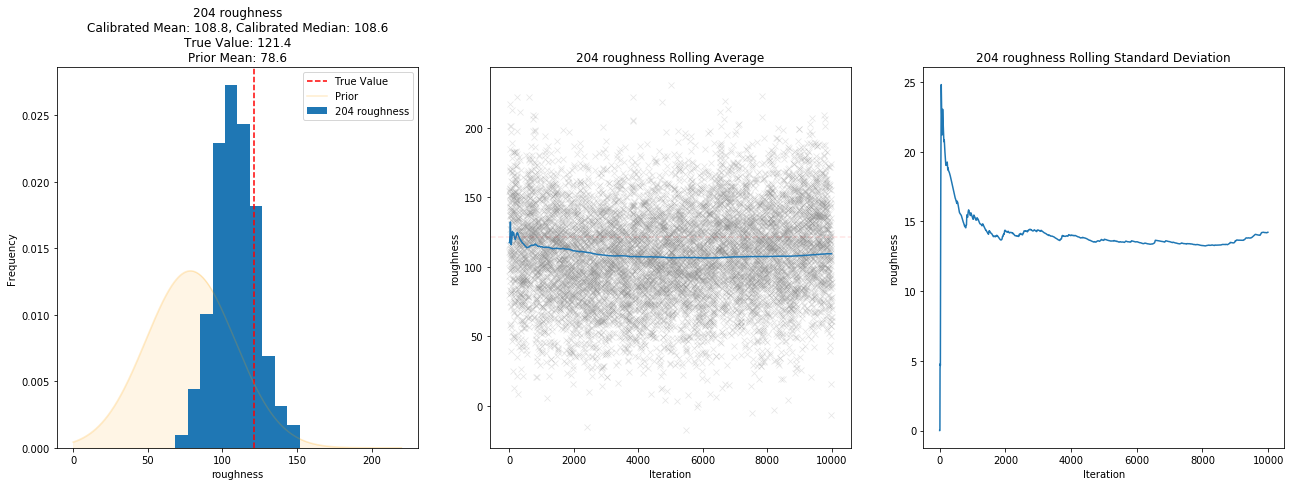

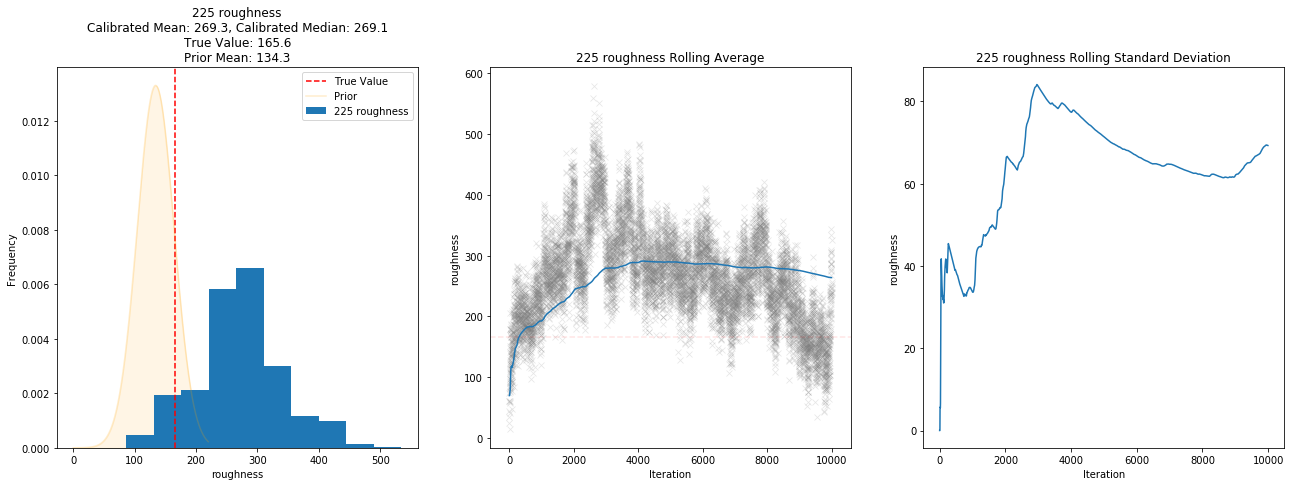

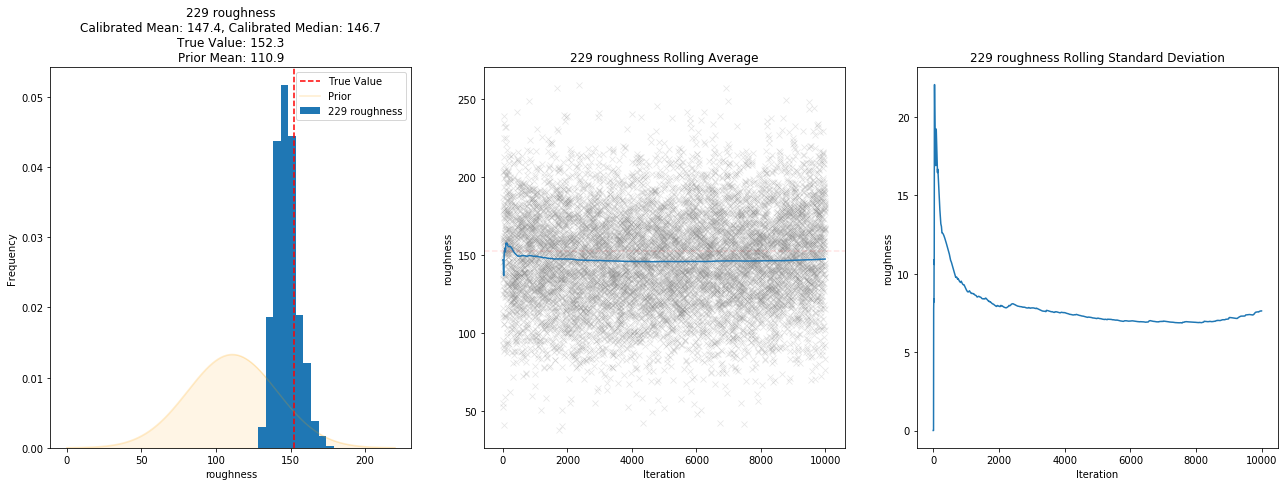

In [44]:
plotCalibratorResults(listOfCalibrators)

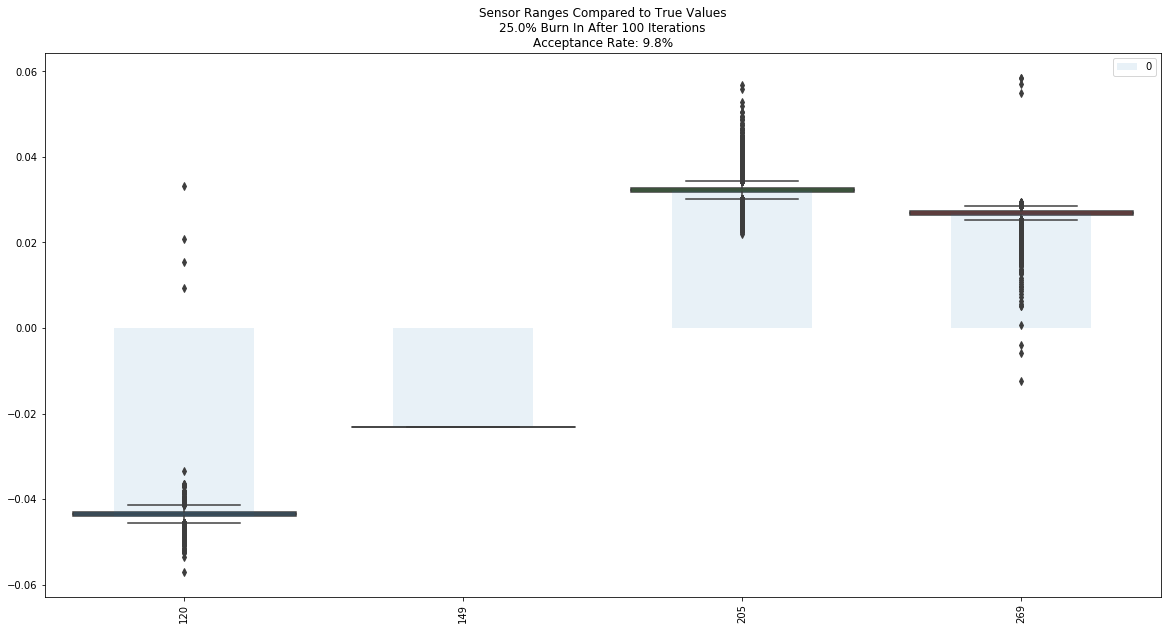

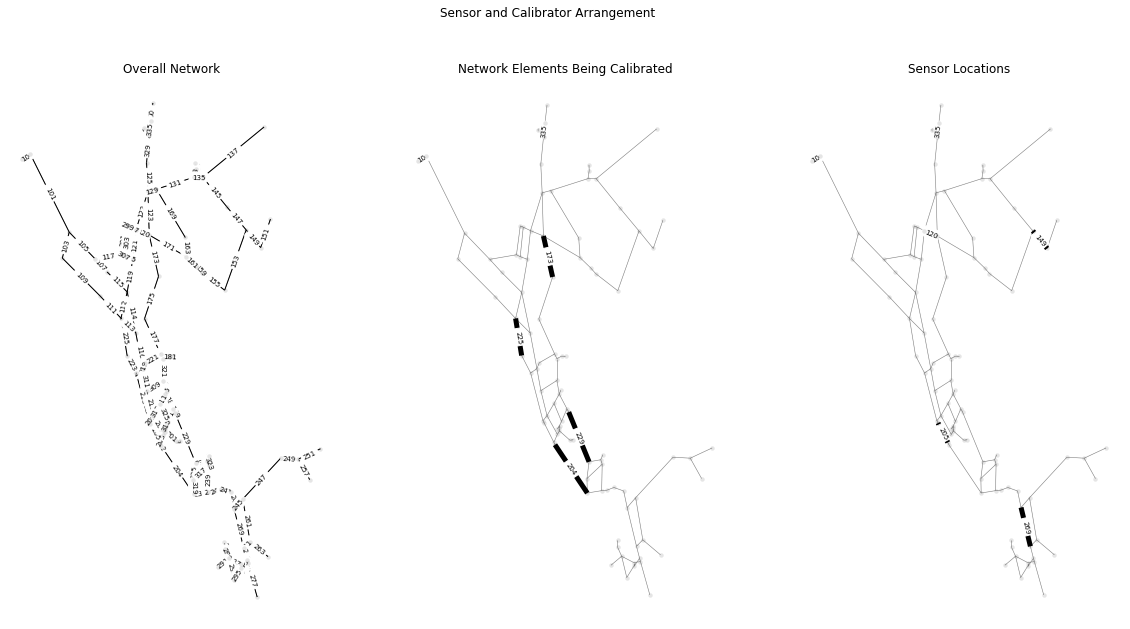

In [48]:
plotNetworkSetup(resultsDict)

In [46]:
savePickle({"name":"10,000 iterations with 4 manual sensors","listOfSensors":listOfSensors,"listOfCalibrators":listOfCalibrators},"trial2.pkl")

In [ ]:
testResults = loadPickle("trial1.pkl")

# Set Up Simple Genetic Algorithm

In [68]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import itertools
import random

In [ ]:
import random

from deap import base
from deap import creator
from deap import tools

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Attribute generator 
#                      define 'attr_bool' to be an attribute ('gene')
#                      which corresponds to integers sampled uniformly
#                      from the range [0,1] (i.e. 0 or 1 with equal
#                      probability)
toolbox.register("attr_bool", random.randint, 0, 1)

# Structure initializers
#                         define 'individual' to be an individual
#                         consisting of 100 'attr_bool' elements ('genes')
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_bool, 100)

# define the population to be a list of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# the goal ('fitness') function to be maximized
def evalOneMax(individual):
    return sum(individual),

#----------
# Operator registration
#----------
# register the goal / fitness function
toolbox.register("evaluate", evalOneMax)

# register the crossover operator
toolbox.register("mate", tools.cxTwoPoint)

# register a mutation operator with a probability to
# flip each attribute/gene of 0.05
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)

# operator for selecting individuals for breeding the next
# generation: each individual of the current generation
# is replaced by the 'fittest' (best) of three individuals
# drawn randomly from the current generation.
toolbox.register("select", tools.selTournament, tournsize=3)

#----------



# create an initial population of 300 individuals (where
# each individual is a list of integers)
pop = toolbox.population(n=300)

# CXPB  is the probability with which two individuals
#       are crossed
#
# MUTPB is the probability for mutating an individual
CXPB, MUTPB = 0.5, 0.2

print("Start of evolution")

# Evaluate the entire population
fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

print("  Evaluated %i individuals" % len(pop))

# Extracting all the fitnesses of 
fits = [ind.fitness.values[0] for ind in pop]

# Variable keeping track of the number of generations
g = 0

# Begin the evolution
while max(fits) < 100 and g < 1000:
    # A new generation
    g = g + 1
    print("-- Generation %i --" % g)

    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):

        # cross two individuals with probability CXPB
        if random.random() < CXPB:
            toolbox.mate(child1, child2)

            # fitness values of the children
            # must be recalculated later
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:

        # mutate an individual with probability MUTPB
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    print("  Evaluated %i individuals" % len(invalid_ind))

    # The population is entirely replaced by the offspring
    pop[:] = offspring

    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5

    print("  Min %s" % min(fits))
    print("  Max %s" % max(fits))
    print("  Avg %s" % mean)
    print("  Std %s" % std)

print("-- End of (successful) evolution --")

best_ind = tools.selBest(pop, 1)[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))

# Polynomial Chaos Expansion

In [32]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pytest
import chaospy as cp
import pandas as pd

In [90]:
# Use ChasosPy to define the distributions for the problem.  Multiple distributions are supported by defualt.
distribution_x = cp.J(cp.Normal(),cp.Normal(),cp.Normal())
distribution_y = cp.J(cp.Uniform(0,1),cp.Uniform(0,1))

In [91]:
coefs_x = [6,2,0.2,2.3,-1.5,-0.8]
x1_x = [0,2,3,1,0,0]
x2_x = [0,0,0,1,2,0]
x3_x = [0,0,0,0,0,1]
df_x = pd.DataFrame({"Coefficient":coefs_x,0:x1_x,1:x2_x,2:x3_x})
df_x

Coefficient  0  1  2
0          6.0  0  0  0
1          2.0  2  0  0
2          0.2  3  0  0
3          2.3  1  1  0
4         -1.5  0  2  0
5         -0.8  0  0  1

In [92]:
coefs_y = [-15,0.05,3.2,0.3]
y1_y = [0,0,1,0]
y2_y = [0,2,1,2]
df_y = pd.DataFrame({"Coefficient":coefs_y,0:y1_y,1:y2_y})
df_y

Coefficient  0  1
0       -15.00  0  0
1         0.05  0  2
2         3.20  1  1
3         0.30  0  2

In [33]:
"""
Takes the dataframe representation of coefficients and variable orders and allows this to be treated like
an equation, taking inputs and returning the evaluation.  Very simple but I think a pretty clean
way to represent the models used in task three. Most importantly, makes it much easier to evaluate
ChaosPy polynomials in my opinion.

Inputs:
coefsDF (Pandas DataFrame) -> a data structure I created for this assignment where the first column
                              is the coefficient of each term, and each subsequent numbered column
                              is a variable index
varsArray (list or numpy array) -> the coordinates at which the function is being evaluated

Returns:
valueToReturn (float) -> The value of the function represented by coefsDF at the coordinates represented
                        by varsArray
"""
def matrixToEquation(coefsDF,varsArray):
    valueToReturn = 0.0
    for i,row in coefsDF.iterrows():
        rowValue = row["Coefficient"]
        for j,var in enumerate(varsArray):
            rowValue *= np.power(var,row[j])
        valueToReturn += rowValue
    return valueToReturn

In [34]:
# this is kludgy, but pass the two coefficinent matrices and an array of variables where
# the place which is (min,max) is the study (non-fixed) variable and the other values are fixed
def plotComparison(correctCoefs,generatedCoefs,arr,title='',nSamples=100):
    correctEvaluations = []
    generatedEvaluations = []
    indexOfVariable = [i for i in range(len(arr)) if type(arr[i]) == tuple][0]
    lowerBound = arr[indexOfVariable][0]
    upperBound = arr[indexOfVariable][1]
    varValues = np.linspace(lowerBound,upperBound,nSamples)
    for varValue in varValues:
        variableInput = []
        for varLoc,varVal in enumerate(arr):
            if varLoc == indexOfVariable:
                variableInput.append(varValue)
            else:
                variableInput.append(varVal)
        correctEvaluation = matrixToEquation(correctCoefs,variableInput)
        generatedEvaluation = matrixToEquation(generatedCoefs,variableInput)
        correctEvaluations.append(correctEvaluation)
        generatedEvaluations.append(generatedEvaluation)
    fig,ax = plt.subplots(figsize=(10,5))
    ax.plot(varValues,correctEvaluations,label="Correct")
    ax.scatter(varValues,generatedEvaluations,label="Test",marker="*",color="red",alpha=0.5)
    ax.set_title(title)
    ax.legend()

In [106]:
"""
Creates a pretty-print string representation of the polynomial represented by the pandas dataframe,
written to look nice in LaTex.  The cutoff will drop (from printing, not from analyzing) any coefficient
with an absolute value less than the cutoff.  Coefficients are rounded for printing based upon rounding.
"""
def convertDFGeneratedToEquation(df_Generated,variableName="X",cutoff=0.001,rounding=3):
    df_Generated_Filtered = df_Generated[np.abs(df_Generated["Coefficient"]) >= cutoff]
    variables = list(df_Generated.columns)[1:]
    strRepresentation = ""
    for i,row in df_Generated_Filtered.iterrows():
        if row["Coefficient"] >= 0:
            term = f"+{round(row['Coefficient'],rounding)}"
        else:
            term = f"{round(row['Coefficient'],rounding)}"
        for variablePosition,variable in enumerate(variables):
            # implement different variable name if string or list
            if type(variableName) == str:
                if row[variable] != 0:
                    term += f"{variableName}_{variable+1}^{int(row[variable])}" # the variable + 1 is to be congruent with the 1-based indexing of the assignment
            # assume list is ordered same as problem
            elif type(variableName) == list:
                term += f"{variableName[variablePosition]}^{int(row[variable])}" # the variable + 1 is to be congruent with the 1-based indexing of the assignment
        strRepresentation += term
    return strRepresentation

In [36]:
"""
This function implements task three directly, with the examples below demonstrating how it can be
used to implement tasks one and two.  

Inputs:
distribution (Pandas DataFrame) -> a data structure I created for this assignment where the first column
                              is the coefficient of each term, and each subsequent numbered column
                              is a variable index
            
simulationDistribution (Pandas DataFrame) -> The same data structure as above to represent the polynomials
                                             being modeled.  Please note that it is very easy to replace this
                                             with an actual simulation, or any generator of choice.
                                        
order (int) -> The order to be evaluated.  As noted in the discussion, order < 2 produces unpredictable results

sampleRule (string) -> The polynomial type, including "gaussian", "gauss_legendre"

Returns:
df_Generated (Pandas DataFrame) -> a data structure I created for this assignment where the first column
                              is the coefficient of each term, and each subsequent numbered column
                              is a variable index
"""
def generatePolynomialSurrogate(distribution,simulationDistribution,order,sampleRule="gauss_legendre"):
    orthogonal_expansion = cp.orth_ttr(order, distribution)
    samples,weights = cp.generate_quadrature(order,distribution,rule=sampleRule)
    solves = np.array([matrixToEquation(simulationDistribution,sample) for sample in samples.T])
    approx_model = cp.fit_regression(orthogonal_expansion, samples, solves)
    nVars = approx_model.exponents.shape[1]
    dataDict = {'Coefficient':approx_model.coefficients}
    for varIndex in range(0,nVars):
        dataDict[varIndex] = approx_model.exponents[:,varIndex]
    df_Generated = pd.DataFrame(dataDict)
    return df_Generated

[20.582 19.308 18.121 16.847 19.38  18.106 16.919 15.645 11.413 10.139  8.952  7.678 -4.486 -5.76  -6.947 -8.221  4.696  3.422  2.235  0.961  9.327  8.053  6.866  5.592  6.795  5.521  4.334  3.06  -3.271 -4.545 -5.732 -7.006 -3.108 -4.382 -5.569 -6.843  6.958  5.684  4.497  3.223  9.491  8.217
  7.03   5.756  4.86   3.586  2.399  1.125  0.603 -0.671 -1.858 -3.132 16.501 15.227 14.04  12.766 24.469 23.195 22.008 20.734 25.67  24.396 23.209 21.935]


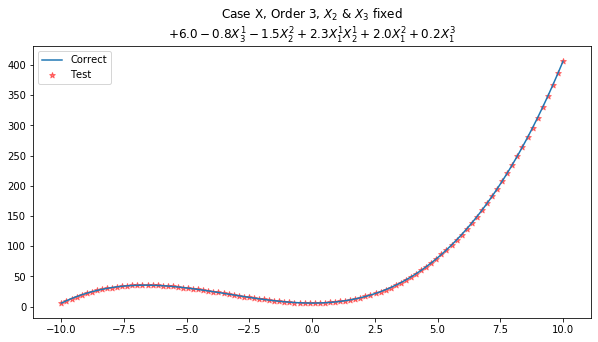

In [99]:
df_Generated = generatePolynomialSurrogate(distribution_x,df_x,3,sampleRule="gaussian")
plotComparison(df_x,df_Generated,[(-10,10),0,0],title=f"Case X, Order 3, $X_2$ & $X_3$ fixed\n${convertDFGeneratedToEquation(df_Generated)}$")

In [80]:
distribution = cp.J(cp.Normal(170,30),cp.Normal(170,30),cp.Normal(170,30),cp.Normal(122,30))
distribution = cp.J(cp.Uniform(100,200),cp.Uniform(100,200),cp.Uniform(100,200),cp.Uniform(100,200))
distribution = cp.J(cp.Normal(0.002,0.001),cp.Normal(0.002,0.001),cp.Normal(0.002,0.001),cp.Normal(0.002,0.001))
order = 3
sampleRule = "gauss_legendre"

In [81]:
wn_true = wntr.network.WaterNetworkModel(inp_file)
waterNetwork = WaterNetworkHelper(wn_true)
listOfCalibrators = generateListOfCalibrators(waterNetwork,["204","225","229","173"],calibrationParameter="roughness",calibratorSTD=30)

Text(0.5, 1.0, 'Distribution of Node Demands')

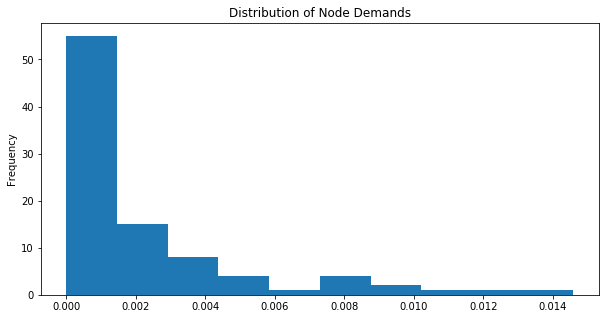

In [118]:
fig,ax = plt.subplots(figsize=(10,5))
waterNetwork.nodes["base_demand"].plot(kind="hist",ax=ax,density=False)
ax.set_title("Distribution of Node Demands")

In [120]:
waterNetwork.nodes.sort_values("base_demand",ascending=False).head()

base_demand     coordinates demand  \
name                                       
109      0.014599  (17.64, 18.92)   None   
101      0.011984  (13.81, 22.94)   None   
119      0.011112   (23.7, 22.76)   None   
151      0.009115  (28.29, 21.39)   None   
111      0.008955  (20.21, 17.53)   None   

                                 demand_timeseries_list  elevation  head  \
name                                                                       
109   [<TimeSeries: base=0.014599071446960002, patte...    6.18744  None   
101   [<TimeSeries: base=0.01198398280618, pattern='...   12.80160  None   
119   [<TimeSeries: base=0.011112076291932, pattern=...    0.60960  None   
151   [<TimeSeries: base=0.009115271575872, pattern=...   10.21080  None   
111   [<TimeSeries: base=0.008955022477016, pattern=...    3.04800  None   

      initial_quality  leak_area leak_demand  leak_discharge_coeff  \
name                                                                 
109               0.0        0.0        None                   0.0   
101               0.0        0.0        None                   0.0   
119               0.0        0.0        None                   0.0   
151               0.0        0.0        None                   0.0   
111               0.0        0.0        None                   0.0   

      leak_status  minimum_pressure node_type  nominal_pressure   tag  
name                                                                   
109         False               0.0  Junction              20.0  None  
101         False               0.0  Junction              20.0  None  
119         False               0.0  Junction              20.0  None  
151         False               0.0  Junction              20.0  None  
111         False               0.0  Junction              20.0  None

In [82]:
waterNetwork.generateNetworkStatistics()
pipesToSense = list(waterNetwork.pipes.sort_values("highest_node_current_flow_betweenness_centrality").iloc[0:1].index)
listOfSensors = generateListOfSensors(waterNetwork,pipesToSense)

In [124]:
def solve(parameterValues,waterNetwork,parameterElements = ["173","204","225","229"],demand=False):
    for i,parameterValue in enumerate(parameterValues):
        parameterValue = max(parameterValue,0.0) # to prevent negative numbers
        if not demand:
            waterNetwork.setPipeRoughness(parameterElements[i],parameterValue)
        else:
            waterNetwork.setNodeDemand(parameterElements[i],parameterValue)
    try:
        simulationResults = waterNetwork.runSimulation()
        simulationValues = generateSensorResults(listOfSensors,simulationResults)
    except:
        simulationValues = [0]
    return simulationValues

In [125]:
solve([.002,.002,.001,.150],waterNetwork,parameterElements=["109","101","119","151"],demand=True)

[-0.15982774]

In [84]:
solve([120,130,140,150],waterNetwork)

[0.031274933]

In [85]:
orthogonal_expansion = cp.orth_ttr(order, distribution)
samples,weights = cp.generate_quadrature(order,distribution,rule=sampleRule)
solves = []
for sample in samples.T:
    solves.append(solve(sample,waterNetwork))
solves = np.array(solves)
# solves = np.array([matrixToEquation(simulationDistribution,sample) for sample in samples.T]) # This is where I enter the simulation!
approx_model = cp.fit_regression(orthogonal_expansion, samples, solves)
nVars = approx_model.exponents.shape[1]
dataDict = {'Coefficient':approx_model.coefficients}
for varIndex in range(0,nVars):
    dataDict[varIndex] = approx_model.exponents[:,varIndex]
df_Generated = pd.DataFrame(dataDict)

In [86]:
df_Generated["Coefficient"] = [x[0] for x in df_Generated["Coefficient"]]

In [107]:
convertDFGeneratedToEquation(df_Generated,"X",cutoff=0.00000001,rounding=7)

'-0.0335287+0.000705X_4^1-2.9e-06X_4^2+3.07e-05X_3^1-0.0X_3^1X_4^1-1e-07X_3^2+0.0001069X_2^1-7e-07X_2^1X_4^1-2e-07X_2^2+0.0001546X_1^1-6e-07X_1^1X_4^1-1e-07X_1^1X_3^1-1e-07X_1^1X_2^1-4e-07X_1^2'

In [110]:
convertDFGeneratedToEquation(df_Generated,["Roughness_204","Roughness_225","Roughness_229","Roughness_173"],cutoff=0.00000001,rounding=7)

'-0.0335287Roughness_204^0Roughness_225^0Roughness_229^0Roughness_173^0+0.000705Roughness_204^0Roughness_225^0Roughness_229^0Roughness_173^1-2.9e-06Roughness_204^0Roughness_225^0Roughness_229^0Roughness_173^2+3.07e-05Roughness_204^0Roughness_225^0Roughness_229^1Roughness_173^0-0.0Roughness_204^0Roughness_225^0Roughness_229^1Roughness_173^1-1e-07Roughness_204^0Roughness_225^0Roughness_229^2Roughness_173^0+0.0001069Roughness_204^0Roughness_225^1Roughness_229^0Roughness_173^0-7e-07Roughness_204^0Roughness_225^1Roughness_229^0Roughness_173^1-2e-07Roughness_204^0Roughness_225^2Roughness_229^0Roughness_173^0+0.0001546Roughness_204^1Roughness_225^0Roughness_229^0Roughness_173^0-6e-07Roughness_204^1Roughness_225^0Roughness_229^0Roughness_173^1-1e-07Roughness_204^1Roughness_225^0Roughness_229^1Roughness_173^0-1e-07Roughness_204^1Roughness_225^1Roughness_229^0Roughness_173^0-4e-07Roughness_204^2Roughness_225^0Roughness_229^0Roughness_173^0'

In [95]:
df_Generated

Coefficient  0  1  2  3
0  -3.352865e-02  0  0  0  0
1   7.050090e-04  0  0  0  1
2  -2.892855e-06  0  0  0  2
3   4.447165e-09  0  0  0  3
4   3.070800e-05  0  0  1  0
5  -4.080931e-08  0  0  1  1
6   4.406741e-11  0  0  1  2
7  -8.451107e-08  0  0  2  0
8   4.419306e-11  0  0  2  1
9   1.016429e-10  0  0  3  0
10  1.069398e-04  0  1  0  0
11 -7.051094e-07  0  1  0  1
12  1.392355e-09  0  1  0  2
13 -6.067850e-09  0  1  1  0
14 -1.863924e-11  0  1  1  1
15  1.064196e-11  0  1  2  0
16 -1.514389e-07  0  2  0  0
17  4.986354e-10  0  2  0  1
18  3.551749e-12  0  2  1  0
19  7.884326e-11  0  3  0  0
20  1.545597e-04  1  0  0  0
21 -6.425482e-07  1  0  0  1
22  5.415528e-10  1  0  0  2
23 -8.676201e-08  1  0  1  0
24  7.738080e-11  1  0  1  1
25  6.128382e-11  1  0  2  0
26 -8.575406e-08  1  1  0  0
27  1.218541e-10  1  1  0  1
28  2.327267e-11  1  1  1  0
29  9.580937e-12  1  2  0  0
30 -4.225489e-07  2  0  0  0
31  1.163086e-09  2  0  0  1
32  1.261873e-10  2  0  1  0
33  1.588766e-10  2  1  0  0
34  3.000912e-10  3  0  0  0

In [128]:
for calibrator in listOfCalibrators:
    print(calibrator.elementName)

173
204
225
229


In [120]:
# build the distribution
distributions = []
for calibrator in listOfCalibrators:
    dist = cp.Normal(calibrator.prior.mean(),calibrator.prior.std())
    distributions.append(dist)
distribution = cp.J(distributions)

AssertionError: 